**Community detection**

In [ ]:
!pip install python-louvain
!pip install scikit-network
!pip install cdlib

## Utils

In [47]:
import networkx as nx
from networkx import edge_betweenness_centrality as betweenness
from networkx.algorithms import community
from community import community_louvain
from sknetwork.hierarchy import Paris, cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_dendrogram
from sknetwork.hierarchy.postprocess import cut_straight

import cdlib
from cdlib.algorithms import big_clam

import pandas as pd
import numpy as np
import itertools
from operator import itemgetter
import re


from google.colab import files
from IPython.display import SVG
import matplotlib.pyplot as plt

In [2]:
def network_from_edges(edges):
  dict_edges = {}
  for ind in range(len(edges)):
    if edges.iloc[ind,2] > 10:
      dict_edges[(edges.iloc[ind,0], edges.iloc[ind,1])] = edges.iloc[ind,2]
  net = pd.DataFrame.from_dict(dict_edges,orient='index')
  net.columns = ["weight"]
  net.sort_values(by="weight",inplace=True, ascending=False)
  return dict_edges, net


def get_graph(network):
  G = nx.Graph()
  for edge in network:
      #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
      G.add_edge(edge[0], edge[1], weight=network[edge])
  
  #G.add_weighted_edges_from(up_weighted, weight='weight')
  return G


def extract_text(df):       #extract the text from the tweets and RT
                            #works ONLY on .csv file
    list_strings = []
    for index in range(len(df)):
        #print(index)
        text = df.loc[index]['text']                          #if it is nor trucated nor a RT  i take "text"
        string = -1
        if (df.loc[index,"truncated"] == True):                 #if it is trucated I take "extended_tweet"
            string = df.loc[index,"extended_tweet"]
        if type(df.loc[index,"retweeted_status"]) != float:     #if it is a RT I take retweeted_status
            string = df.loc[index,"retweeted_status"]
        if type(string) == str :
            if(re.search('full_text\':(.+?)https',string) != None):     #if I find "full_text"
                s = re.search('full_text\':(.+?)https',string).group(1)
            if(re.search('text\':(.+?)https',string)!= None):
                s = re.search('text\':(.+?)https',string).group(1)
            else:  #here then one should remove the http
                if (re.search('full_text\':\s\'(.+?)\'',string)!=None) :
                    s=re.search('full_text\':\s\'(.+?)\'',string).group(1)  
                if (re.search('\{\\\'full_text\\\':\s(.+?)\"',string)!=None) : 
                    re.search('\{\\\'full_text\\\':\s(.+?)\"',string).group(1)
            
            list_strings.append(s)
            #print(s)         
        else:
            list_strings.append(text)
            #print(text)
      

    return list_strings


def frequency_dictionary(df):
  unique_words = {}

  for row in df:
    for word in row.split():
      #if the word is encountered for the first time add to dict as key and set its value to 0
      unique_words.setdefault(word,0)
      #increase the value (i.e the count) of the word by 1 every time it is encountered
      unique_words[word] += 1

  return unique_words


def adj_matrix(node_list, edge_list):   

  words = sorted(list(node_list['Id']))

  A = pd.DataFrame(np.zeros((len(words),len(words))), columns = words, index = words)
  print('A shape: ', A.shape)
  for row in range(len(edge_list)):
    if row%1000==0:
      print(str(round(row/1000)) + '/' + str(round(len(edge_list)/1000)))
    word1 = edge_list.iloc[row, 0]
    word2 = edge_list.iloc[row, 1]
    weight = edge_list.iloc[row, 2]
    A[word1, word2] = weight
    A[word2, word1] = weight
  print('A shape: ', A.shape)
  return A

In [3]:
def community_check(community, dict_1, dict_2, G_1, G_2, thr):
  sum_1 = 0
  sum_2 = 0
  sum_12 = 0
  for key in community:
    if (key in list(dict_1.keys())) and (key in list(dict_2.keys())):
      if dict_1[key] / sum(list(dict_1.values())) - dict_2[key] / sum(list(dict_2.values())) > thr:
        sum_1 += 1
      elif dict_1[key] / sum(list(dict_1.values())) - dict_2[key] / sum(list(dict_2.values())) < -thr:
        sum_2 += 1  
      else:
        sum_12 += 1 
    elif key in list(G_1.nodes()):
      sum_1 += 1
    elif key in list(G_2.nodes()):
      sum_2 += 1
  return sum_1, sum_2, sum_12

In [4]:
# Functions for measuring the quality of a partition (into communities).

def compute_metrics(G, partition):

  # Returns the coverage of a partition.
  coverage = community.coverage(G, partition)

  # Returns the coverage and performance of a partition of G.
  quality = community.partition_quality(G, partition)

  performance = community.performance(G, partition)

  # Returns the modularity of the given partition of the graph.
  modularity = community.modularity(G, partition)

  print("Coverage: ", coverage)
  # print("Quality: ", quality) # Coverage and performance
  print("Performance: ", performance)
  print("Modularity: ", modularity)

  return coverage, quality, performance, modularity


In [5]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=0.5)

    pos_nodes = _position_nodes(g, partition, scale=2.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.circular_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.random_layout(subgraph)
        pos.update(pos_subgraph)

    return pos

# PageRank Networks: inside/outside together

## **All periods**

### Download data

In [555]:
China = pd.read_csv('/content/China.csv')
USA = pd.read_csv('/content/USA.csv',)

edges = pd.read_csv('/content/edgelist_China_USA.csv')
edges_China = pd.read_csv('/content/edgelist_China.csv')
edges_USA = pd.read_csv('/content/edgelist_USA.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)

G = get_graph(net)
nodes = G.nodes()
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [556]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  509
Edges:  12061
Is connected:  True

China:
Words:  17019

USA:
Words:  33536


In [557]:
# Graph without search keys
G_original = G.copy()
G.remove_node('coronavirus')
G.remove_node('covid')
G.remove_node('vaccine')

In [558]:
print('Is connected: ', nx.is_connected(G))

Is connected:  True


In [559]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  return pd.DataFrame(l)

def threshold_reverse(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] < threshold ]

  return pd.DataFrame(l)

In [560]:
# PageRank for reducing the graph
pr = nx.algorithms.pagerank(G, alpha = 1)
pr = dict(sorted(pr.items(), key=lambda item: item[1],reverse = True))

thr = 0.002
len(threshold(pr,thr))

110

In [561]:
G_reduced = G.copy()
nodes_to_delete = list(threshold_reverse(pr,thr)[0])
for n in nodes_to_delete:
    G_reduced.remove_node(n)

nx.is_connected(G_reduced)

True

### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [26]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

print(community_bipart[0])
print(community_bipart[1])

{'street', 'korea', 'ask', 'exclusive', 'urge', 'small', 'facility', 'build', 'volunteer', 'launch', 'major', 'express', 'secretary', 'post', 'likely', 'step', 'economic', 'system', 'worry', 'term', 'whether', 'look', 'conference', 'young', 'life', 'much', 'stay', 'read', 'impact', 'appear', 'side', 'rule', 'cancel', 'california', 'soon', 'growth', 'reopen', 'press', 'deadly', 'stock', 'department', 'several', 'illness', 'like', 'yet', 'watch', 'relief', 'man', 'republican', 'office', 'research', 'head', 'special', 'recent', 'general', 'aid', 'force', 'rare', 'area', 'keep', 'severe', 'ease', 'turn', 'effect', 'russia', 'maker', 'scientist', 'ahead', 'bank', 'germany', 'job', 'employee', 'population', 'shut', 'adviser', 'community', 'researcher', 'seek', 'beijing', 'hope', 'vote', 'condition', 'issue', 'move', 'seven', 'statement', 'america', 'contact', 'party', 'sign', 'base', 'push', 'member', 'prevent', 'boost', 'combat', 'age', 'north', 'deal', 'financial', 'transmission', 'already

In [28]:
threshold = 0.001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  4 %
USA:  7 %
China&USA:  90 %

China:  10 %
USA:  2 %
China&USA:  88 %


**Metrics**

In [29]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.7084312435379265
Performance:  0.5357022658787618
Modularity:  0.007131826085145357


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [31]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')

community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['ask', 'small', 'say', 'leader', 'secretary', 'post', 'likely', 'team', 'well', 'whether', 'look', 'conference', 'next', 'positive', 'much', 'rule', 'california', 'house', 'soon', 'chief', 'press', 'test', 'stock', 'return', 'first', 'several', 'like', 'democratic', 'relief', 'republican', 'office', 'come', 'general', 'diagnosis', 'aid', 'remain', 'know', 'severe', 'turn', 'ahead', 'job', 'employee', 'adviser', 'nominee', 'vote', 'hope', 'move', 'condition', 'statement', 'push', 'contact', 'party', 'base', 'member', 'election', 'deal', 'trump', 'within', 'experience', 'military', 'fauci', 'information', 'limit', 'right', 'add', 'recovery', 'symptom', 'bill', 'mark', 'court', 'official', 'diagnose', 'top', 'provide', 'question', 'contract', 'event', 'joe', 'extend', 'news', 'also', 'president', 'breaking', 'critical', 'game', 'plan', 'doctor', 'lady', 'analysis', 'director', 'release', 'share', 'senior', 'vice', 'give', 'change', 'without', 'take', 'good', 'former', 'today', 'would', '

In [32]:
threshold = 0.001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  2 %
USA:  10 %
China&USA:  88 %

Community:  1
China:  12 %
USA:  1 %
China&USA:  87 %

Community:  2
China:  12 %
USA:  3 %
China&USA:  85 %

Community:  3
China:  2 %
USA:  1 %
China&USA:  96 %

Community:  4
China:  2 %
USA:  3 %
China&USA:  95 %

Community:  5
China:  10 %
USA:  10 %
China&USA:  80 %

Community:  6
China:  38 %
USA:  12 %
China&USA:  50 %



**Metrics**

In [33]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.36215809756556067
Performance:  0.7797440613626581
Modularity:  0.22075503010940023


#### display

In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [34]:
community_louv = community_louvain.best_partition(G,weight='weight')

max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['continue', 'reach', 'fall', 'case', 'million', 'death', 'accord', 'new', 'state', 'united', 'hard', 'confirm', 'half', 'country', 'across', 'nation', 'since', 'arrive', 'nearly', 'third', 'number', 'drop', 'day', 'include', 'australia', 'daily', 'week', 'almost', 'total', 'begin', 'one', 'national', 'commission', 'high', 'start', 'three', 'increase', 'second', 'slow', 'confirmed', 'see', 'far', 'report', 'toll', 'another', 'infection', 'bring', 'ministry', 'rate', 'last', 'receive', 'russia', 'month', 'two', 'warn', 'time', 'rise', 'set', 'capital', 'low', 'single', 'hour', 'restriction', 'region', 'place', 'past', 'five', 'launch', 'level', 'hit', 'area', 'expect', 'germany', 'march', 'force', 'drive', 'brazil', 'pass', 'record', 'ease', 'recent', 'open', 'batch', 'administer', 'dos', 'vaccination', 'population', 'wave', 'surge', 'export', 'york', 'india', 'france', 'canada', 'french', 'surpass', 'school', 'italy', 'governor', 'four', 'less', 'reopen', 'spike', 'seven', 'decline', '

In [38]:
threshold = 0.001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  11 %
USA:  3 %
China&USA:  86 %

Community:  1
China:  10 %
USA:  10 %
China&USA:  80 %

Community:  2
China:  0 %
USA:  5 %
China&USA:  95 %

Community:  3
China:  1 %
USA:  0 %
China&USA:  99 %

Community:  4
China:  10 %
USA:  1 %
China&USA:  88 %

Community:  5
China:  36 %
USA:  0 %
China&USA:  64 %

Community:  6
China:  1 %
USA:  11 %
China&USA:  88 %



**Metrics**

In [39]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.38293072657204624
Performance:  0.7537432004069973
Modularity:  0.21918965497213178


#### display

In [ ]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]
colors[:] = [x if x != 5 else 'cyan' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

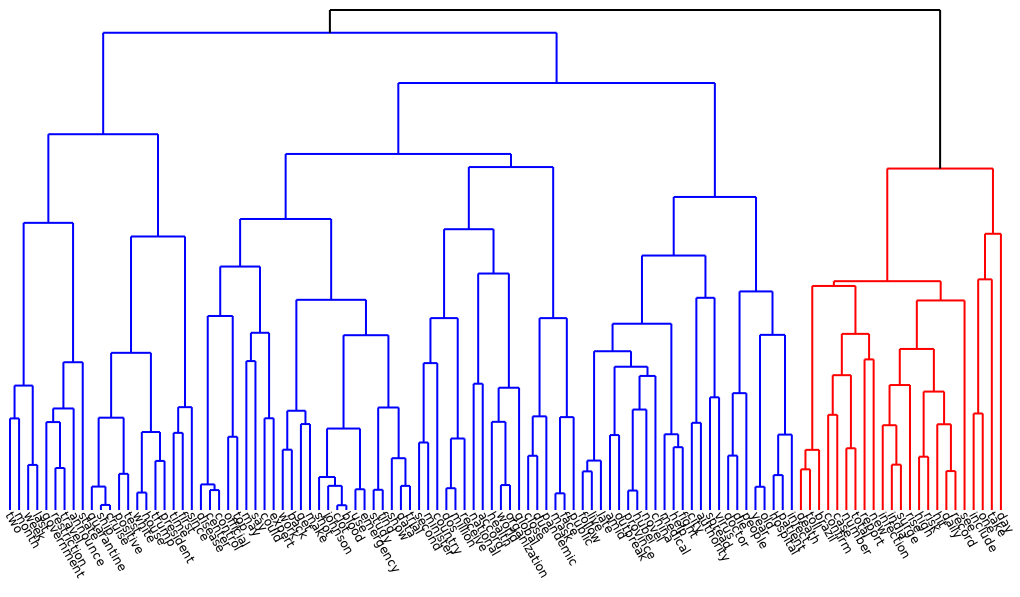

In [562]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G_reduced, nodelist = list(G_reduced.nodes))
dendrogram = paris.fit_transform(adjacency)

names = list(G_reduced.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=False,width=1000,height=500,filename='community_dendogram2_all_periods')
SVG(image)

**Metrics**

In [563]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.6619047619047619
Performance:  0.5152627189324437
Modularity:  0.09872719388313841


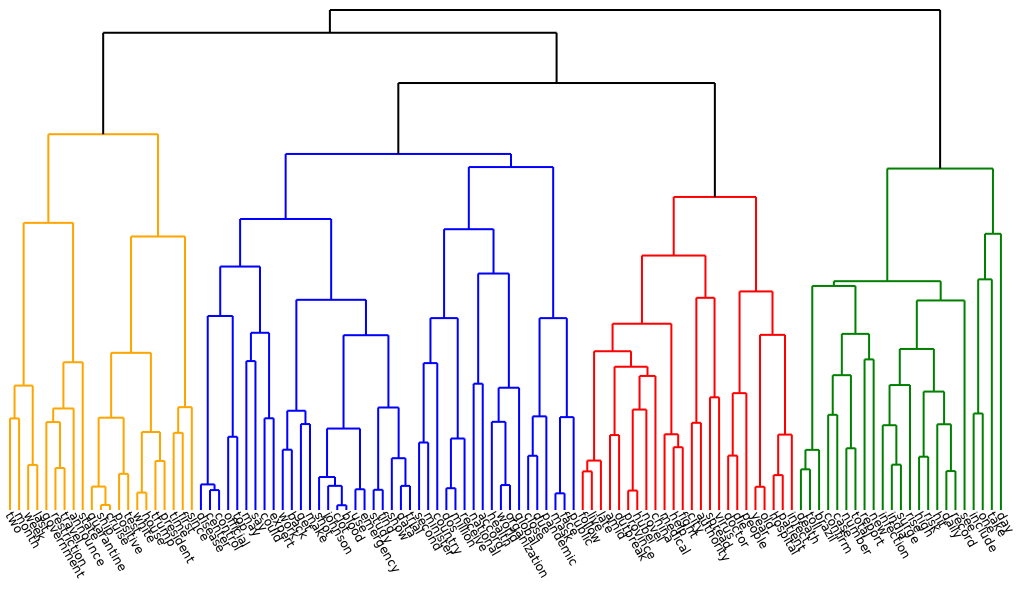

In [564]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=False,width=1000,height=500,filename='community_dendogram4_all_periods')
SVG(image)

**Metrics**

In [565]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.30505952380952384
Performance:  0.5145954962468724
Modularity:  0.15802924091687812


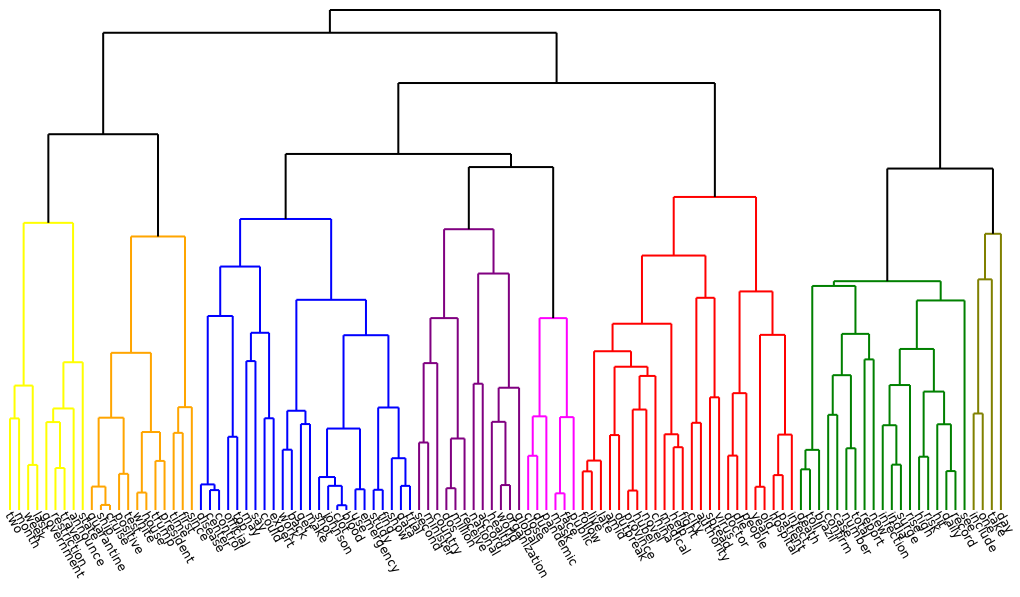

In [566]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=False,width=1000,height=500,filename='community_dendogram8_all_periods')
SVG(image)

**Metrics**

In [567]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.1931547619047619
Performance:  0.5039199332777314
Modularity:  0.15260071516960144


### Big clam

In [49]:
G_copy = G.copy()
G_copy = nx.convert_node_labels_to_integers(G_copy, first_label=0, ordering='sorted')

index_list = [index for index in range(G.number_of_nodes())]
node_list = sorted([node for node in G.nodes()])

clusters = big_clam(G_copy)
communities = clusters.communities

dictionary_bigClam = {}
for idx in index_list:
  dictionary_bigClam[idx] = node_list[idx]

print('Number of communities:', len(communities))

Number of communities: 3


In [50]:
bigClam_comm = [[],[],[]]
for c in range(len(communities)):
  for idx in range(len(communities[c])):
    bigClam_comm[c].append(dictionary_bigClam[communities[c][idx]])

print(bigClam_comm[0])
print(bigClam_comm[1])
print(bigClam_comm[2])

['accord', 'across', 'administration', 'adult', 'already', 'also', 'amid', 'among', 'announce', 'another', 'antibody', 'appear', 'approve', 'area', 'around', 'asian', 'australia', 'authority', 'back', 'bad', 'ban', 'battle', 'become', 'begin', 'big', 'blood', 'brazil', 'bring', 'business', 'california', 'call', 'capital', 'care', 'case', 'cause', 'center', 'central', 'change', 'chief', 'child', 'china', 'city', 'clinical', 'close', 'clot', 'come', 'commission', 'company', 'concern', 'confirm', 'confirmed', 'contain', 'continue', 'control', 'could', 'country', 'critical', 'cruise', 'curb', 'daily', 'data', 'day', 'death', 'decline', 'delay', 'develop', 'die', 'discharge', 'disease', 'doctor', 'dos', 'dose', 'drive', 'drug', 'due', 'early', 'economic', 'economy', 'effective', 'effort', 'emergency', 'employee', 'end', 'epidemic', 'even', 'exclusive', 'expect', 'expert', 'face', 'far', 'fauci', 'fear', 'fight', 'financial', 'find', 'first', 'flight', 'follow', 'four', 'get', 'give', 'globa

In [51]:
for node in G.nodes():
  if node in bigClam_comm[0] and node in bigClam_comm[1]:
    print(node + ' is present in communities 0 and 1')
  if node in bigClam_comm[0] and node in bigClam_comm[2]:
    print(node + ' is present in communities 0 and 2')
  if node in bigClam_comm[1] and node in bigClam_comm[2]:
    print(node + ' is present in communities 1 and 2')

no overlapping

In [52]:
threshold = 0.001
for i in range(len(bigClam_comm)):
  sum_China, sum_USA, sum_China_USA = community_check(bigClam_comm[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(bigClam_comm[i])),'%')
  print('USA: ', round(100 * sum_USA / len(bigClam_comm[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(bigClam_comm[i])),'%')
  print()

Community:  0
China:  10 %
USA:  2 %
China&USA:  88 %

Community:  1
China:  4 %
USA:  7 %
China&USA:  89 %

Community:  2
China:  7 %
USA:  0 %
China&USA:  93 %



**Metrics**

In [53]:
_ = compute_metrics(G, bigClam_comm)

Coverage:  0.6722436319202932
Performance:  0.556122568778617
Modularity:  -0.003273954949254273


#### display

In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in bigClam_comm[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in bigClam_comm[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in bigClam_comm[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

## **JanFeb2020**

### Download data

In [578]:
period = '_JanFeb2020'
China = pd.read_csv('/content/China'+period+'.csv')
USA = pd.read_csv('/content/USA'+period+'.csv',)

edges = pd.read_csv('/content/edgelist_China_USA'+period+'.csv')
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)

G = get_graph(net)
nodes = G.nodes()
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [579]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  453
Edges:  3271
Is connected:  True

China:
Words:  10263

USA:
Words:  10601


In [580]:
# Graph without search keys
G_original = G.copy()
G.remove_node('coronavirus')
G.remove_node('covid')
G.remove_node('vaccine')

In [581]:
print('Is connected: ', nx.is_connected(G))

Is connected:  False


In [582]:
for c in nx.connected_components(G):
  print(c)

{'ask', 'record', 'urge', 'build', 'express', 'start', 'step', 'country', 'phone', 'look', 'protective', 'emergency', 'fear', 'much', 'due', 'asia', 'leave', 'rise', 'quarter', 'cause', 'clinical', 'stock', 'first', 'update', 'front', 'man', 'office', 'thailand', 'aid', 'dock', 'singapore', 'scientist', 'investor', 'south', 'community', 'related', 'medical', 'issue', 'miss', 'headline', 'combat', 'deal', 'trade', 'evacuee', 'already', 'send', 'mask', 'japan', 'fall', 'continue', 'symptom', 'official', 'quarantine', 'cut', 'concern', 'ensure', 'makeshift', 'become', 'top', 'prevention', 'flu', 'firm', 'human', 'police', 'race', 'diamond', 'president', 'also', 'way', 'critical', 'taiwan', 'allow', 'die', 'check', 'director', 'release', 'food', 'expect', 'france', 'close', 'child', 'work', 'hubei', 'include', 'amid', 'try', 'take', 'good', 'must', 'reporter', 'least', 'nearly', 'source', 'end', 'state', 'situation', 'join', 'isolation', 'result', 'measure', 'effort', 'staff', 'curb', 'jap

In [583]:
disconn_keys = []
for c in nx.connected_components(G):
  if len(c) == 1:
    disconn_keys.append(list(c)[0])

for key in disconn_keys:
  G.remove_node(key)

In [584]:
print('Is connected: ', nx.is_connected(G))

Is connected:  True


In [585]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  return pd.DataFrame(l)

def threshold_reverse(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] < threshold ]

  return pd.DataFrame(l)

In [586]:
# PageRank for reducing the graph
pr = nx.algorithms.pagerank(G, alpha = 1)
pr = dict(sorted(pr.items(), key=lambda item: item[1],reverse = True))

thr = 0.002
len(threshold(pr,thr))

95

In [587]:
G_reduced = G.copy()
nodes_to_delete = list(threshold_reverse(pr,thr)[0])
for n in nodes_to_delete:
    G_reduced.remove_node(n)

nx.is_connected(G_reduced)

True

### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [64]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

print(community_bipart[0])
print(community_bipart[1])

{'street', 'korea', 'reach', 'ask', 'record', 'urge', 'facility', 'australian', 'major', 'trial', 'low', 'local', 'economic', 'fast', 'system', 'phone', 'look', 'life', 'protective', 'infected', 'much', 'stay', 'read', 'pandemic', 'asia', 'cancel', 'california', 'growth', 'medic', 'quarter', 'clinical', 'threat', 'airport', 'return', 'illness', 'shanghai', 'front', 'watch', 'develop', 'daily', 'office', 'australia', 'research', 'head', 'special', 'come', 'general', 'thailand', 'aid', 'remain', 'force', 'singapore', 'area', 'keep', 'dollar', 'severe', 'nine', 'wall', 'scientist', 'investor', 'recently', 'wish', 'researcher', 'south', 'community', 'condition', 'move', 'issue', 'miss', 'statement', 'contact', 'base', 'party', 'officer', 'headline', 'increase', 'deal', 'trade', 'trump', 'wash', 'evacuee', 'medicine', 'part', 'military', 'mother', 'air', 'five', 'protect', 'information', 'fall', 'recovery', 'newly', 'social', 'infectious', 'four', 'east', 'care', 'cut', 'hundred', 'ensure',

In [65]:
threshold = 0.001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  7 %
USA:  13 %
China&USA:  79 %

China:  14 %
USA:  11 %
China&USA:  74 %


**Metrics**

In [66]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.8364668322100035
Performance:  0.5217325310348566
Modularity:  0.004654394374712387


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [67]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')

community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['street', 'ask', 'urge', 'economy', 'contain', 'may', 'leader', 'major', 'express', 'low', 'step', 'economic', 'fast', 'resident', 'system', 'home', 'country', 'epidemic', 'phone', 'life', 'since', 'much', 'read', 'stay', 'due', 'impact', 'asia', 'cancel', 'california', 'growth', 'quarter', 'deadly', 'jinping', 'stock', 'illness', 'department', 'get', 'like', 'update', 'shanghai', 'watch', 'develop', 'office', 'australia', 'head', 'come', 'travel', 'aid', 'remain', 'force', 'area', 'keep', 'dollar', 'wall', 'scientist', 'investor', 'recently', 'wish', 'outbreak', 'fight', 'move', 'issue', 'contact', 'base', 'party', 'prevent', 'combat', 'deal', 'trade', 'evacuee', 'wash', 'trump', 'part', 'send', 'air', 'mask', 'spreading', 'five', 'protect', 'information', 'across', 'flight', 'support', 'continue', 'supply', 'newly', 'company', 'social', 'east', 'suspend', 'cut', 'ensure', 'hundred', 'market', 'solidarity', 'level', 'asian', 'production', 'strong', 'top', 'large', 'thousand', 'flu', 

In [68]:
threshold = 0.001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  8 %
USA:  15 %
China&USA:  77 %

Community:  1
China:  26 %
USA:  1 %
China&USA:  72 %

Community:  2
China:  15 %
USA:  15 %
China&USA:  69 %

Community:  3
China:  5 %
USA:  2 %
China&USA:  93 %

Community:  4
China:  5 %
USA:  22 %
China&USA:  71 %

Community:  5
China:  0 %
USA:  0 %
China&USA:  100 %



**Metrics**

In [69]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.47321745299751683
Performance:  0.6889467122025261
Modularity:  0.2672778611512895


#### display

In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [70]:
community_louv = community_louvain.best_partition(G,weight='weight')

max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['talk', 'china', 'novel', 'outbreak', 'university', 'medical', 'student', 'face', 'deal', 'medium', 'watch', 'make', 'take', 'hard', 'announce', 'team', 'expert', 'among', 'asia', 'state', 'information', 'office', 'worker', 'across', 'line', 'since', 'medic', 'arrive', 'support', 'local', 'help', 'fight', 'cut', 'firm', 'express', 'contain', 'epidemic', 'nearly', 'risk', 'ensure', 'supply', 'trump', 'try', 'share', 'effort', 'send', 'amid', 'offer', 'system', 'wang', 'mask', 'donate', 'show', 'australia', 'daily', 'begin', 'back', 'work', 'service', 'industry', 'combat', 'get', 'business', 'issue', 'plan', 'possible', 'high', 'raise', 'woman', 'measure', 'home', 'city', 'food', 'come', 'fund', 'battle', 'billion', 'dollar', 'win', 'meet', 'due', 'big', 'beijing', 'economy', 'fast', 'part', 'slow', 'many', 'aid', 'may', 'stand', 'infected', 'see', 'response', 'diagnose', 'much', 'yuan', 'company', 'production', 'president', 'solidarity', 'join', 'leader', 'recently', 'east', 'million',

In [71]:
threshold = 0.001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  10 %
USA:  12 %
China&USA:  77 %

Community:  1
China:  5 %
USA:  3 %
China&USA:  92 %

Community:  2
China:  4 %
USA:  22 %
China&USA:  72 %

Community:  3
China:  16 %
USA:  15 %
China&USA:  69 %

Community:  4
China:  22 %
USA:  2 %
China&USA:  75 %

Community:  5
China:  10 %
USA:  20 %
China&USA:  70 %



**Metrics**

In [72]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.48456899609790705
Performance:  0.6520518241448474
Modularity:  0.2695924737981779


#### display

In [ ]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]
colors[:] = [x if x != 5 else 'cyan' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

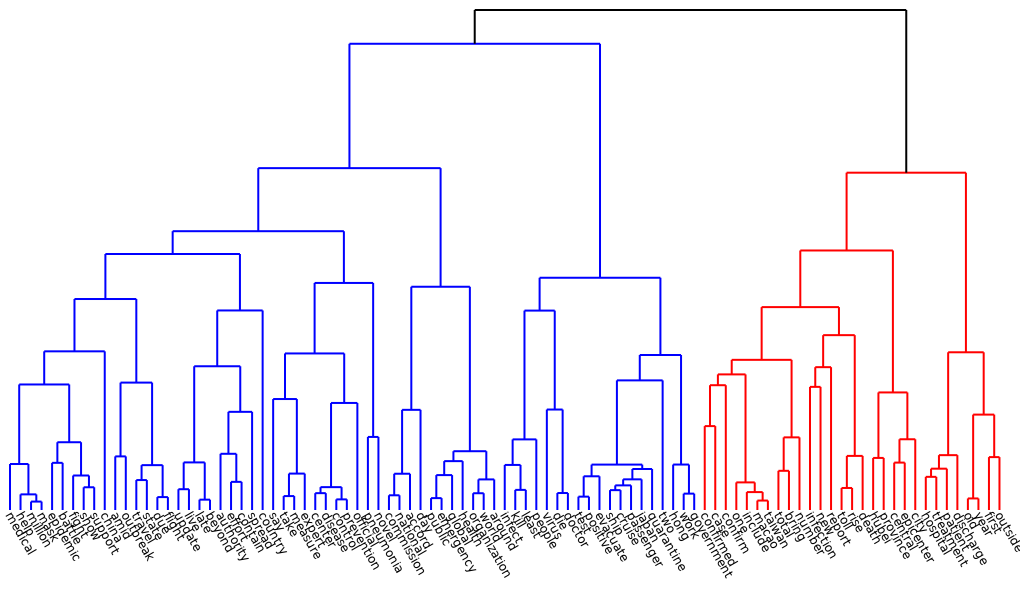

In [588]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G_reduced, nodelist = list(G_reduced.nodes))
dendrogram = paris.fit_transform(adjacency)

names = list(G_reduced.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=False,width=1000,height=500,filename='community_dendogram2'+period)
SVG(image)

**Metrics**

In [589]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.6293706293706294
Performance:  0.5115341545352744
Modularity:  0.1601489332116329


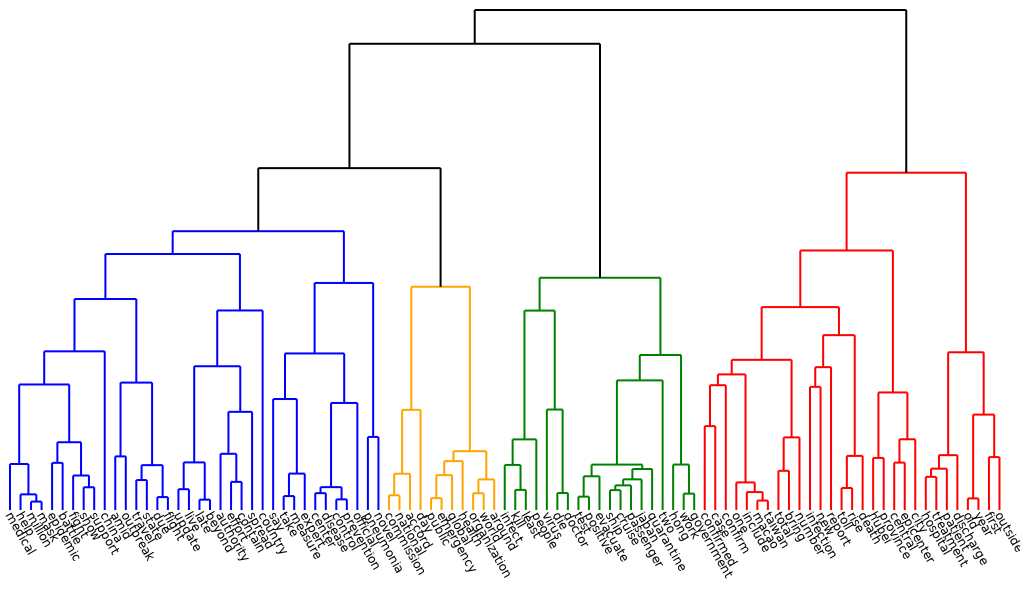

In [590]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=False,width=1000,height=500,filename='community_dendogram4'+period)
SVG(image)

**Metrics**

In [591]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.4244755244755245
Performance:  0.6689809630459127
Modularity:  0.20176358887180185


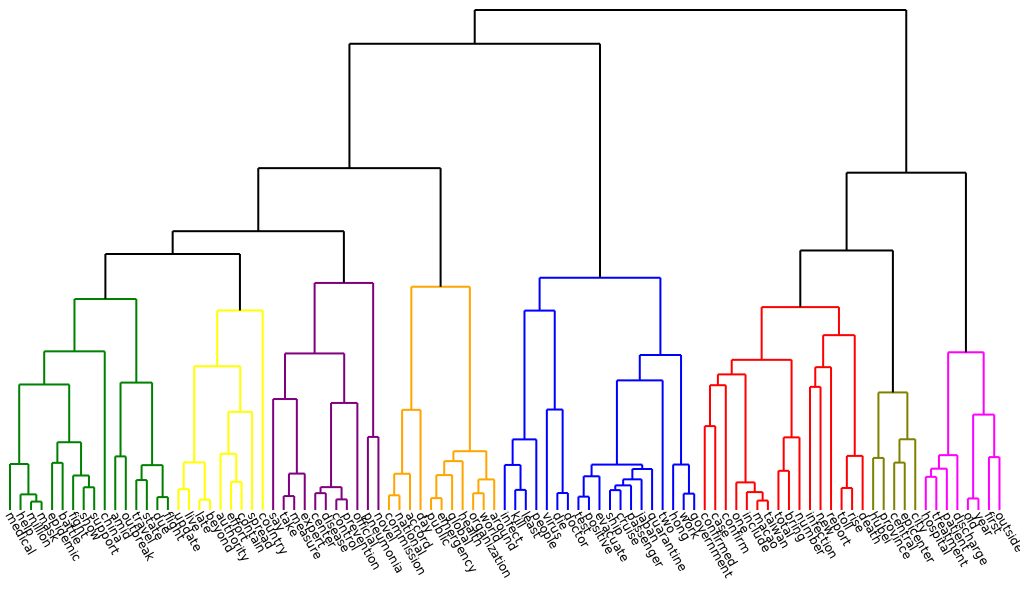

In [592]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=False,width=1000,height=500,filename='community_dendogram8'+period)
SVG(image)

**Metrics**

In [593]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.24895104895104894
Performance:  0.7059350503919373
Modularity:  0.17513355098491284


### Big clam

In [79]:
G_copy = G.copy()
G_copy = nx.convert_node_labels_to_integers(G_copy, first_label=0, ordering='sorted')

index_list = [index for index in range(G.number_of_nodes())]
node_list = sorted([node for node in G.nodes()])

clusters = big_clam(G_copy)
communities = clusters.communities

dictionary_bigClam = {}
for idx in index_list:
  dictionary_bigClam[idx] = node_list[idx]

print('Number of communities:', len(communities))

Number of communities: 3


In [80]:
bigClam_comm = [[],[],[]]
for c in range(len(communities)):
  for idx in range(len(communities[c])):
    bigClam_comm[c].append(dictionary_bigClam[communities[c][idx]])

print(bigClam_comm[0])
print(bigClam_comm[1])
print(bigClam_comm[2])

['aboard', 'across', 'aid', 'air', 'allow', 'already', 'also', 'amid', 'among', 'animal', 'announce', 'another', 'apple', 'around', 'avoid', 'away', 'back', 'ban', 'base', 'battle', 'become', 'bed', 'beijing', 'best', 'beyond', 'big', 'billion', 'board', 'brief', 'build', 'business', 'california', 'call', 'cancel', 'care', 'carry', 'cause', 'central', 'check', 'chief', 'child', 'citizen', 'clinical', 'combat', 'commission', 'community', 'company', 'concern', 'condition', 'conference', 'confidence', 'contact', 'continue', 'critical', 'curb', 'cure', 'cut', 'daily', 'data', 'dead', 'deadly', 'declare', 'demand', 'department', 'despite', 'development', 'diagnose', 'diamond', 'die', 'director', 'dock', 'doctor', 'dollar', 'donate', 'drop', 'due', 'early', 'east', 'economic', 'economy', 'emergency', 'end', 'epicenter', 'evacuate', 'evacuee', 'expect', 'expert', 'express', 'face', 'facility', 'fall', 'family', 'far', 'fast', 'fear', 'find', 'five', 'flight', 'flu', 'follow', 'food', 'force',

In [81]:
for node in G.nodes():
  if node in bigClam_comm[0] and node in bigClam_comm[1]:
    print(node + ' is present in communities 0 and 1')
  if node in bigClam_comm[0] and node in bigClam_comm[2]:
    print(node + ' is present in communities 0 and 2')
  if node in bigClam_comm[1] and node in bigClam_comm[2]:
    print(node + ' is present in communities 1 and 2')

no overlapping

In [82]:
threshold = 0.001
for i in range(len(bigClam_comm)):
  sum_China, sum_USA, sum_China_USA = community_check(bigClam_comm[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(bigClam_comm[i])),'%')
  print('USA: ', round(100 * sum_USA / len(bigClam_comm[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(bigClam_comm[i])),'%')
  print()

Community:  0
China:  9 %
USA:  10 %
China&USA:  80 %

Community:  1
China:  13 %
USA:  16 %
China&USA:  70 %

Community:  2
China:  25 %
USA:  0 %
China&USA:  75 %



**Metrics**

In [83]:
_ = compute_metrics(G, bigClam_comm)

Coverage:  0.41858815182688897
Performance:  0.4500352360817477
Modularity:  -0.04560932539559829


#### display

In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in bigClam_comm[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in bigClam_comm[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in bigClam_comm[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

## **SeptOct2020**

### Download data

In [604]:
period = '_SeptOct2020'
China = pd.read_csv('/content/China'+period+'.csv')
USA = pd.read_csv('/content/USA'+period+'.csv',)

edges = pd.read_csv('/content/edgelist_China_USA'+period+'.csv')
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)

G = get_graph(net)
nodes = G.nodes()
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [605]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  507
Edges:  5778
Is connected:  True

China:
Words:  6223

USA:
Words:  19469


In [606]:
# Graph without search keys
G_original = G.copy()
G.remove_node('coronavirus')
G.remove_node('covid')
G.remove_node('vaccine')

In [607]:
print('Is connected: ', nx.is_connected(G))

Is connected:  False


In [608]:
for c in nx.connected_components(G):
  print(c)

{'jersey', 'record', 'ask', 'wave', 'urge', 'single', 'happen', 'start', 'message', 'country', 'look', 'expose', 'young', 'rally', 'much', 'emergency', 'fear', 'brazil', 'due', 'rise', 'surpass', 'leave', 'cause', 'clinical', 'stock', 'authorization', 'serious', 'first', 'update', 'relief', 'even', 'office', 'aid', 'turn', 'effect', 'maker', 'scientist', 'job', 'employee', 'south', 'seek', 'medical', 'issue', 'sign', 'deal', 'already', 'send', 'mask', 'fauci', 'fall', 'right', 'candidate', 'continue', 'symptom', 'mark', 'court', 'winter', 'official', 'quarantine', 'review', 'supporter', 'concern', 'previous', 'become', 'top', 'prevention', 'flu', 'firm', 'joe', 'package', 'race', 'wife', 'register', 'president', 'also', 'way', 'half', 'clear', 'allow', 'die', 'director', 'struggle', 'release', 'dose', 'food', 'stage', 'expect', 'france', 'close', 'child', 'work', 'include', 'school', 'amid', 'try', 'take', 'good', 'speaker', 'nancy', 'least', 'nearly', 'democrat', 'immune', 'source', '

In [609]:
disconn_keys = []
for c in nx.connected_components(G):
  if len(c) == 1:
    disconn_keys.append(list(c)[0])

for key in disconn_keys:
  G.remove_node(key)

In [610]:
print('Is connected: ', nx.is_connected(G))

Is connected:  True


In [611]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  return pd.DataFrame(l)

def threshold_reverse(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] < threshold ]

  return pd.DataFrame(l)

In [612]:
# PageRank for reducing the graph
pr = nx.algorithms.pagerank(G, alpha = 1)
pr = dict(sorted(pr.items(), key=lambda item: item[1],reverse = True))

thr = 0.002
len(threshold(pr,thr))

93

In [613]:
G_reduced = G.copy()
nodes_to_delete = list(threshold_reverse(pr,thr)[0])
for n in nodes_to_delete:
    G_reduced.remove_node(n)

nx.is_connected(G_reduced)

True

### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [94]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

print(community_bipart[0])
print(community_bipart[1])

{'korea', 'past', 'record', 'exclusive', 'wave', 'economy', 'confirm', 'volunteer', 'immunity', 'single', 'contain', 'health', 'may', 'gathering', 'major', 'trial', 'live', 'low', 'vulnerable', 'surge', 'start', 'local', 'resident', 'novel', 'home', 'worry', 'country', 'term', 'epidemic', 'look', 'pay', 'kill', 'life', 'real', 'young', 'since', 'expert', 'old', 'due', 'pandemic', 'impact', 'appear', 'side', 'brazil', 'prime', 'month', 'might', 'soon', 'milestone', 'rise', 'surpass', 'reopen', 'clinical', 'cause', 'bar', 'serious', 'illness', 'get', 'report', 'update', 'total', 'watch', 'daily', 'authority', 'australia', 'research', 'head', 'recent', 'force', 'keep', 'ease', 'nine', 'effect', 'maker', 'russia', 'scientist', 'qingdao', 'germany', 'see', 'bank', 'infect', 'job', 'shut', 'researcher', 'south', 'another', 'outbreak', 'york', 'issue', 'seven', 'sign', 'india', 'boost', 'increase', 'north', 'study', 'financial', 'organization', 'accord', 'already', 'part', 'within', 'five', '

In [95]:
threshold = 0.001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  8 %
USA:  12 %
China&USA:  80 %

China:  3 %
USA:  19 %
China&USA:  78 %


**Metrics**

In [96]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.7233811386353759
Performance:  0.5174829659318637
Modularity:  0.2634417280019071


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [97]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')

community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['jersey', 'ask', 'small', 'say', 'happen', 'leader', 'kamala', 'secretary', 'post', 'likely', 'message', 'team', 'well', 'system', 'whether', 'expose', 'senate', 'rally', 'next', 'positive', 'much', 'stay', 'rule', 'house', 'chief', 'leave', 'press', 'twitter', 'test', 'stock', 'return', 'first', 'several', 'play', 'like', 'democratic', 'even', 'feel', 'republican', 'office', 'public', 'center', 'sen', 'treatment', 'travel', 'general', 'come', 'diagnosis', 'remain', 'know', 'turn', 'ahead', 'penny', 'activity', 'employee', 'adviser', 'reed', 'player', 'fight', 'nominee', 'vote', 'hope', 'night', 'move', 'medical', 'condition', 'statement', 'push', 'member', 'party', 'base', 'reduce', 'contact', 'election', 'supreme', 'hick', 'trump', 'experience', 'send', 'military', 'air', 'mask', 'fauci', 'flight', 'right', 'protocol', 'add', 'continue', 'recovery', 'mark', 'symptom', 'supply', 'outside', 'court', 'four', 'official', 'care', 'supporter', 'quarantine', 'become', 'top', 'receive', 're

In [98]:
threshold = 0.001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  3 %
USA:  19 %
China&USA:  77 %

Community:  1
China:  12 %
USA:  7 %
China&USA:  81 %

Community:  2
China:  1 %
USA:  18 %
China&USA:  81 %

Community:  3
China:  2 %
USA:  20 %
China&USA:  78 %

Community:  4
China:  0 %
USA:  40 %
China&USA:  60 %

Community:  5
China:  0 %
USA:  29 %
China&USA:  71 %

Community:  6
China:  0 %
USA:  0 %
China&USA:  100 %



**Metrics**

In [99]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.5760538896132117
Performance:  0.7289779559118237
Modularity:  0.3008924129312971


#### display

In [100]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [102]:
community_louv = community_louvain.best_partition(G,weight='weight')

max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['daily', 'case', 'infection', 'high', 'since', 'number', 'new', 'hit', 'record', 'italy', 'week', 'report', 'health', 'time', 'increase', 'death', 'month', 'country', 'rise', 'france', 'see', 'expert', 'surpass', 'million', 'toll', 'confirm', 'one', 'resurgence', 'accord', 'ministry', 'register', 'national', 'student', 'university', 'local', 'across', 'global', 'pass', 'surge', 'close', 'government', 'bring', 'total', 'tally', 'india', 'brazil', 'winter', 'milestone', 'outbreak', 'spread', 'measure', 'past', 'hour', 'city', 'china', 'day', 'state', 'single', 'set', 'york', 'russia', 'qingdao', 'last', 'united', 'fall', 'germany', 'start', 'spike', 'authority', 'six', 'school', 'region', 'gathering', 'restriction', 'seven', 'nine', 'nation', 'nationwide', 'compare', 'large', 'nearly', 'bar', 'rate', 'australia', 'low', 'impose', 'french', 'level', 'ease', 'another', 'warn', 'half', 'curb', 'research', 'trend', 'slow', 'federal', 'medium', 'join', 'business', 'mayor', 'hard', 'place', '

In [103]:
threshold = 0.001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  14 %
USA:  7 %
China&USA:  79 %

Community:  1
China:  4 %
USA:  19 %
China&USA:  77 %

Community:  2
China:  2 %
USA:  18 %
China&USA:  81 %

Community:  3
China:  3 %
USA:  16 %
China&USA:  81 %

Community:  4
China:  0 %
USA:  31 %
China&USA:  69 %



**Metrics**

In [104]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.5236853541938288
Performance:  0.7501803607214429
Modularity:  0.29796753092768163


#### display

In [ ]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]
colors[:] = [x if x != 5 else 'cyan' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

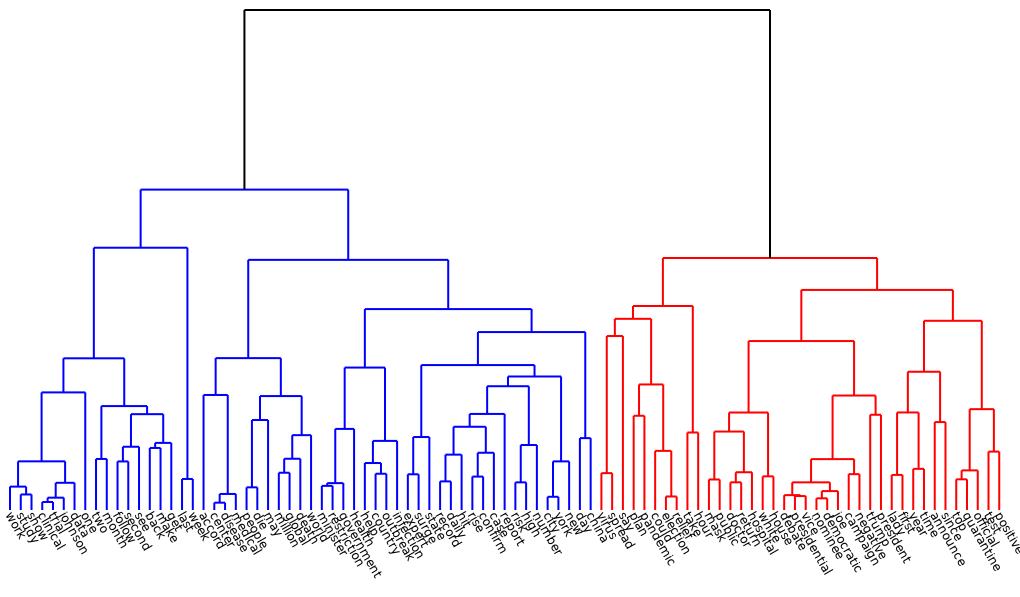

In [614]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G_reduced, nodelist = list(G_reduced.nodes))
dendrogram = paris.fit_transform(adjacency)

names = list(G_reduced.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=False,width=1000,height=500,filename='community_dendogram2'+period)
SVG(image)

**Metrics**

In [615]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.6247594611930725
Performance:  0.5794763908368397
Modularity:  0.2191017852287217


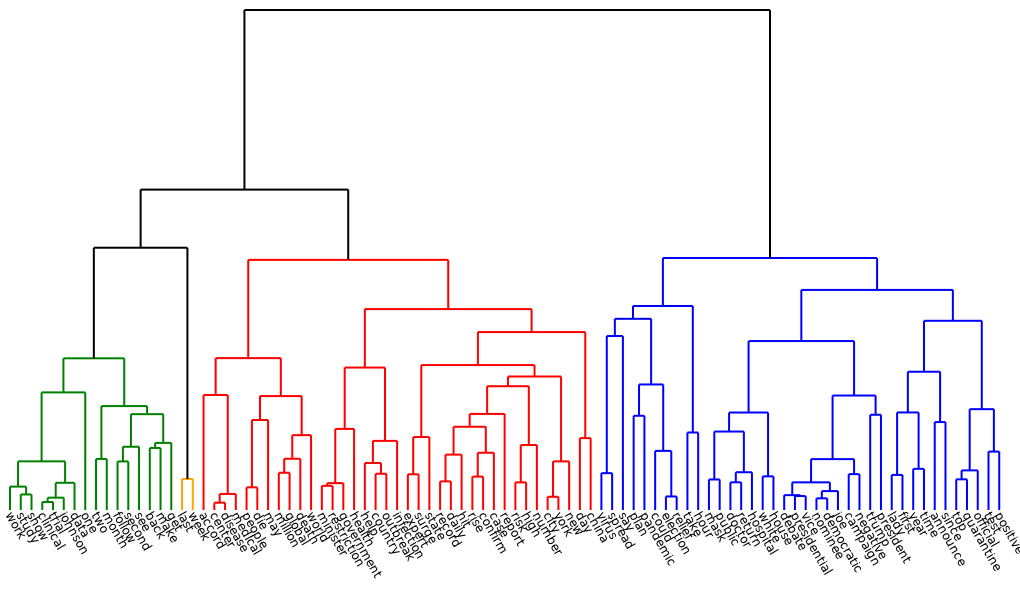

In [616]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=False,width=1000,height=500,filename='community_dendogram4'+period)
SVG(image)

**Metrics**

In [617]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.4836433611289288
Performance:  0.6397849462365591
Modularity:  0.23037344914931737


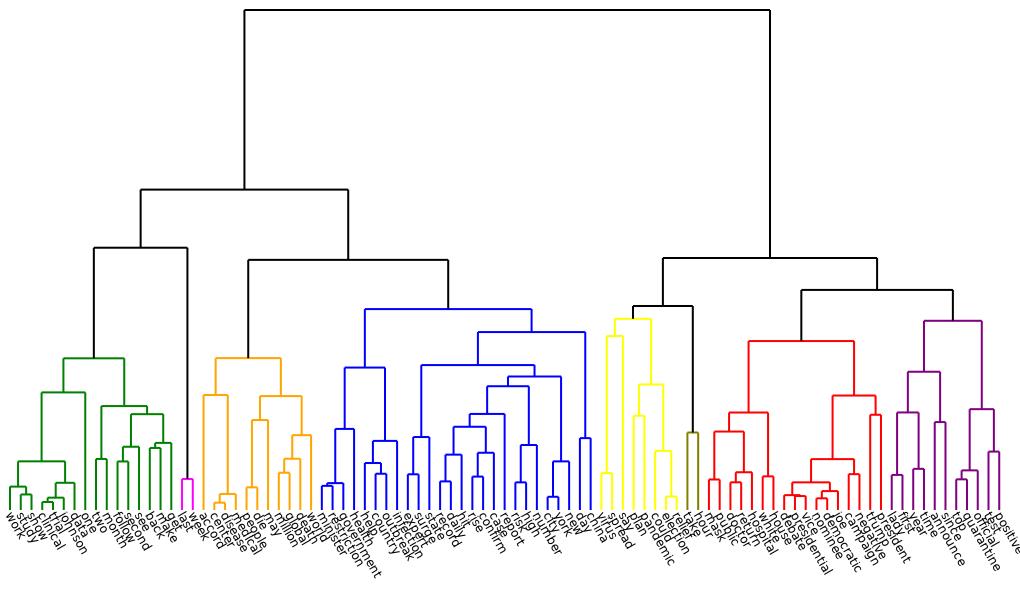

In [618]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=False,width=1000,height=500,filename='community_dendogram8'+period)
SVG(image)

**Metrics**

In [619]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.2835150737652341
Performance:  0.6736792893875643
Modularity:  0.19499273510864562


### Big clam

In [111]:
G_copy = G.copy()
G_copy = nx.convert_node_labels_to_integers(G_copy, first_label=0, ordering='sorted')

index_list = [index for index in range(G.number_of_nodes())]
node_list = sorted([node for node in G.nodes()])

clusters = big_clam(G_copy)
communities = clusters.communities

dictionary_bigClam = {}
for idx in index_list:
  dictionary_bigClam[idx] = node_list[idx]

print('Number of communities:', len(communities))

Number of communities: 3


In [112]:
bigClam_comm = [[],[],[]]
for c in range(len(communities)):
  for idx in range(len(communities[c])):
    bigClam_comm[c].append(dictionary_bigClam[communities[c][idx]])

print(bigClam_comm[0])
print(bigClam_comm[1])
print(bigClam_comm[2])

['across', 'activity', 'add', 'administration', 'adult', 'africa', 'ahead', 'aid', 'aide', 'allow', 'almost', 'already', 'also', 'america', 'amid', 'among', 'amy', 'announce', 'another', 'antibody', 'appear', 'approval', 'approve', 'around', 'ask', 'australia', 'authority', 'available', 'bank', 'bar', 'battle', 'become', 'begin', 'benefit', 'big', 'bill', 'billion', 'boom', 'boost', 'breaking', 'bring', 'british', 'business', 'call', 'campaign', 'candidate', 'care', 'catch', 'cause', 'center', 'challenge', 'change', 'chief', 'child', 'claim', 'clear', 'climate', 'clinical', 'close', 'come', 'company', 'compare', 'concern', 'condition', 'confirm', 'contact', 'continue', 'control', 'court', 'crisis', 'curb', 'deal', 'debate', 'delay', 'democrat', 'democratic', 'despite', 'develop', 'development', 'diagnosis', 'die', 'director', 'disease', 'doctor', 'dose', 'drug', 'due', 'early', 'ease', 'economic', 'economy', 'effort', 'election', 'emergency', 'employee', 'enough', 'epidemic', 'event', 

In [113]:
for node in G.nodes():
  if node in bigClam_comm[0] and node in bigClam_comm[1]:
    print(node + ' is present in communities 0 and 1')
  if node in bigClam_comm[0] and node in bigClam_comm[2]:
    print(node + ' is present in communities 0 and 2')
  if node in bigClam_comm[1] and node in bigClam_comm[2]:
    print(node + ' is present in communities 1 and 2')

no overlapping

In [114]:
threshold = 0.001
for i in range(len(bigClam_comm)):
  sum_China, sum_USA, sum_China_USA = community_check(bigClam_comm[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(bigClam_comm[i])),'%')
  print('USA: ', round(100 * sum_USA / len(bigClam_comm[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(bigClam_comm[i])),'%')
  print()

Community:  0
China:  4 %
USA:  19 %
China&USA:  77 %

Community:  1
China:  8 %
USA:  9 %
China&USA:  82 %

Community:  2
China:  0 %
USA:  0 %
China&USA:  100 %



**Metrics**

In [115]:
_ = compute_metrics(G, bigClam_comm)

Coverage:  0.4330725771403737
Performance:  0.41048496993987976
Modularity:  -0.03922693139648818


#### display

In [116]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in bigClam_comm[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in bigClam_comm[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in bigClam_comm[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

## **MarchApril2021**

### Download data

In [630]:
period = '_MarchApril2021'
China = pd.read_csv('/content/China'+period+'.csv')
USA = pd.read_csv('/content/USA'+period+'.csv',)

edges = pd.read_csv('/content/edgelist_China_USA'+period+'.csv')
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

text_China = extract_text(China)
text_USA = extract_text(USA)

freq_dict_China = frequency_dictionary(text_China)
freq_dict_China = dict(sorted(freq_dict_China.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

freq_dict_USA = frequency_dictionary(text_USA)
freq_dict_USA = dict(sorted(freq_dict_USA.items(), key=lambda item: item[1], reverse = True))   #order from more frequent to less frequent word

net, net_df = network_from_edges(edges)
net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)

G = get_graph(net)
nodes = G.nodes()
G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [631]:
print('China&USA:')
print('Nodes: ',len(G.nodes()))
print('Edges: ',len(G.edges()))
print('Is connected: ',nx.is_connected(G))
print()
print('China:')
print('Words: ',len(freq_dict_China))
print()
print('USA:')
print('Words: ',len(freq_dict_USA))

China&USA:
Nodes:  499
Edges:  3051
Is connected:  True

China:
Words:  5858

USA:
Words:  12540


In [632]:
# Graph without search keys
G_original = G.copy()
G.remove_node('coronavirus')
G.remove_node('covid')
G.remove_node('vaccine')

In [633]:
print('Is connected: ', nx.is_connected(G))

Is connected:  False


In [634]:
for c in nx.connected_components(G):
  print(c)

{'record', 'ask', 'mass', 'wave', 'urge', 'single', 'launch', 'fourth', 'start', 'country', 'look', 'young', 'emergency', 'much', 'fear', 'brazil', 'due', 'rise', 'surpass', 'cause', 'clinical', 'authorization', 'first', 'detect', 'update', 'even', 'office', 'thailand', 'effect', 'maker', 'scientist', 'south', 'speak', 'seek', 'medical', 'issue', 'shipment', 'sign', 'union', 'deal', 'send', 'intensive', 'mask', 'fauci', 'japan', 'fall', 'right', 'continue', 'mark', 'official', 'review', 'committee', 'concern', 'reason', 'block', 'become', 'top', 'prevention', 'outweigh', 'joe', 'register', 'way', 'president', 'suffer', 'half', 'link', 'allow', 'director', 'release', 'forward', 'dose', 'expect', 'program', 'france', 'close', 'child', 'work', 'include', 'school', 'amid', 'take', 'must', 'least', 'nearly', 'source', 'end', 'state', 'agency', 'safe', 'campaign', 'white', 'join', 'nation', 'result', 'forecast', 'adult', 'jab', 'effort', 'overseas', 'efficacy', 'world', 'potential', 'help', 

In [635]:
disconn_keys = []
for c in nx.connected_components(G):
  if len(c) == 1:
    disconn_keys.append(list(c)[0])

for key in disconn_keys:
  G.remove_node(key)

In [636]:
print('Is connected: ', nx.is_connected(G))

Is connected:  True


In [637]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  return pd.DataFrame(l)

def threshold_reverse(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] < threshold ]

  return pd.DataFrame(l)

In [638]:
# PageRank for reducing the graph
pr = nx.algorithms.pagerank(G, alpha = 1)
pr = dict(sorted(pr.items(), key=lambda item: item[1],reverse = True))

thr = 0.002
len(threshold(pr,thr))

100

In [639]:
G_reduced = G.copy()
nodes_to_delete = list(threshold_reverse(pr,thr)[0])
for n in nodes_to_delete:
    G_reduced.remove_node(n)

nx.is_connected(G_reduced)

True

### Bipartition
Partition a graph into two blocks using the Kernighan–Lin algorithm.

In [149]:
community_bipart = community.kernighan_lin_bisection(G,weight='weight')

print(community_bipart[0])
print(community_bipart[1])

{'record', 'symptomatic', 'mass', 'wave', 'economy', 'launch', 'leader', 'approval', 'major', 'live', 'fourth', 'low', 'trial', 'chile', 'likely', 'surge', 'secretary', 'local', 'team', 'well', 'home', 'inoculation', 'look', 'life', 'since', 'positive', 'fear', 'much', 'brazil', 'month', 'passport', 'house', 'rise', 'threat', 'reopen', 'clinical', 'surpass', 'test', 'hop', 'black', 'detect', 'illness', 'several', 'report', 'like', 'update', 'total', 'watch', 'daily', 'center', 'research', 'special', 'remain', 'severe', 'ease', 'maker', 'see', 'province', 'another', 'researcher', 'york', 'seek', 'speak', 'hope', 'variant', 'medical', 'issue', 'seven', 'sign', 'base', 'india', 'control', 'prevent', 'boost', 'increase', 'study', 'deal', 'misinformation', 'part', 'investigation', 'within', 'intensive', 'air', 'fauci', 'japan', 'five', 'ever', 'information', 'decision', 'protect', 'limit', 'right', 'add', 'early', 'mark', 'disease', 'case', 'governor', 'social', 'care', 'break', 'reason', '

In [150]:
threshold = 0.001
sum_China_0, sum_USA_0, sum_China_USA_0 = community_check(community_bipart[0], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
sum_China_1, sum_USA_1, sum_China_USA_1 = community_check(community_bipart[1], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)

print('First community:')
print('China: ', round(100 * sum_China_0 / len(community_bipart[0])),'%')
print('USA: ', round(100 * sum_USA_0 / len(community_bipart[0])),'%')
print('China&USA: ', round(100 * sum_China_USA_0 / len(community_bipart[0])),'%')
print()
print('China: ', round(100 * sum_China_1 / len(community_bipart[1])),'%')
print('USA: ', round(100 * sum_USA_1 / len(community_bipart[1])),'%')
print('China&USA: ', round(100 * sum_China_USA_1 / len(community_bipart[1])),'%')

First community:
China:  6 %
USA:  17 %
China&USA:  76 %

China:  10 %
USA:  13 %
China&USA:  77 %


**Metrics**

In [151]:
_ = compute_metrics(G, community_bipart)

Coverage:  0.729106628242075
Performance:  0.5133349366479754
Modularity:  0.206713731945885


### Modularity-based communities
Find communities in G using greedy modularity maximization.

In [152]:
community_mod = community.greedy_modularity_communities(G, n_communities=2, weight='weight')

community_mod_list = []
for comm in community_mod:
 print(list(comm))
 community_mod_list.append(list(comm))

['ask', 'top', 'exclusive', 'delivery', 'economy', 'confirm', 'outweigh', 'say', 'recommend', 'may', 'approval', 'brain', 'contract', 'protection', 'secretary', 'low', 'concern', 'likely', 'use', 'well', 'woman', 'british', 'breaking', 'meet', 'open', 'link', 'federal', 'next', 'begin', 'consider', 'emergency', 'blood', 'big', 'due', 'allow', 'plan', 'impact', 'side', 'target', 'delay', 'soon', 'chief', 'threat', 'director', 'cause', 'hop', 'executive', 'win', 'authorization', 'share', 'expect', 'senior', 'deliver', 'follow', 'even', 'back', 'develop', 'give', 'australia', 'disorder', 'drug', 'remain', 'rare', 'know', 'effect', 'maker', 'scientist', 'investigate', 'must', 'germany', 'six', 'researcher', 'risk', 'lead', 'seek', 'expand', 'safety', 'source', 'medical', 'agency', 'safe', 'approve', 'find', 'decide', 'clot', 'union', 'increase', 'age', 'slow', 'part', 'medicine', 'regulator', 'investigation', 'within', 'shot', 'call', 'problem', 'protect', 'decision', 'many', 'limit', 'add

In [153]:
threshold = 0.001
for i in range(len(community_mod_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_mod_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_mod_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_mod_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_mod_list[i])),'%')
  print()

Community:  0
China:  3 %
USA:  22 %
China&USA:  75 %

Community:  1
China:  14 %
USA:  5 %
China&USA:  80 %

Community:  2
China:  9 %
USA:  6 %
China&USA:  85 %

Community:  3
China:  18 %
USA:  18 %
China&USA:  64 %

Community:  4
China:  0 %
USA:  20 %
China&USA:  80 %

Community:  5
China:  0 %
USA:  28 %
China&USA:  72 %

Community:  6
China:  12 %
USA:  12 %
China&USA:  75 %

Community:  7
China:  0 %
USA:  0 %
China&USA:  100 %

Community:  8
China:  0 %
USA:  33 %
China&USA:  67 %

Community:  9
China:  0 %
USA:  40 %
China&USA:  60 %

Community:  10
China:  0 %
USA:  50 %
China&USA:  50 %

Community:  11
China:  0 %
USA:  100 %
China&USA:  0 %



**Metrics**

In [154]:
_ = compute_metrics(G, community_mod_list)

Coverage:  0.5768491834774255
Performance:  0.8035011328683721
Modularity:  0.3496867074999233


#### display

In [155]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in community_mod_list[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in community_mod_list[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in community_mod_list[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  if node in community_mod_list[3]:
    colors[i] = 'cyan'
    dict_nodes[node] = 3
  if node in community_mod_list[4]:
    colors[i] = 'dodgerblue'
    dict_nodes[node] = 4
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Louvain Community Detection
Find the best partition of a graph using the Louvain Community Detection Algorithm.

In [156]:
community_louv = community_louvain.best_partition(G,weight='weight')

max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['low', 'say', 'expert', 'could', 'top', 'disease', 'lose', 'child', 'even', 'data', 'would', 'result', 'follow', 'increase', 'africa', 'hospitalization', 'control', 'large', 'tokyo', 'test', 'positive', 'british', 'show', 'base', 'hop', 'director', 'part', 'deliver', 'center', 'prevention', 'need', 'open', 'clinical', 'trial', 'company', 'allow', 'game', 'much', 'share', 'economy', 'japan', 'prevent', 'begin', 'big', 'win', 'medical', 'supply', 'look', 'secretary', 'right', 'delay', 'chile', 'chief', 'lead', 'young', 'may', 'still', 'hope', 'slow', 'threat', 'release', 'add', 'effective', 'well', 'safe', 'level', 'efficacy', 'remain', 'approval', 'research', 'potential', 'early', 'reason', 'within', 'information', 'symptomatic', 'illness', 'executive', 'scientist', 'severe', 'protect', 'likely', 'know', 'researcher', 'exclusive', 'investigation', 'want', 'breaking', 'protection', 'delivery', 'source', 'infectious', 'forward', 'must']
['one', 'country', 'second', 'people', 'million', '

In [157]:
threshold = 0.001
for i in range(len(community_louvain_list)):
  sum_China, sum_USA, sum_China_USA = community_check(community_louvain_list[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(community_louvain_list[i])),'%')
  print('USA: ', round(100 * sum_USA / len(community_louvain_list[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(community_louvain_list[i])),'%')
  print()

Community:  0
China:  3 %
USA:  21 %
China&USA:  76 %

Community:  1
China:  9 %
USA:  10 %
China&USA:  80 %

Community:  2
China:  0 %
USA:  33 %
China&USA:  67 %

Community:  3
China:  0 %
USA:  13 %
China&USA:  87 %

Community:  4
China:  19 %
USA:  8 %
China&USA:  73 %

Community:  5
China:  0 %
USA:  27 %
China&USA:  73 %

Community:  6
China:  14 %
USA:  11 %
China&USA:  75 %

Community:  7
China:  0 %
USA:  50 %
China&USA:  50 %

Community:  8
China:  7 %
USA:  16 %
China&USA:  76 %



**Metrics**

In [158]:
_ = compute_metrics(G, community_louvain_list)

Coverage:  0.5278578290105668
Performance:  0.8246775438907383
Modularity:  0.3564179894791457


#### display

In [ ]:
colors = list(community_louv.values())

colors[:] = [x if x != 0 else 'violet' for x in colors]
colors[:] = [x if x != 1 else 'dodgerblue' for x in colors]
colors[:] = [x if x != 2 else 'lawngreen' for x in colors]
colors[:] = [x if x != 3 else 'pink' for x in colors]
colors[:] = [x if x != 4 else 'lightcoral' for x in colors]
colors[:] = [x if x != 5 else 'cyan' for x in colors]

In [ ]:
pos = community_layout(G, community_louv)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

### Dendogram

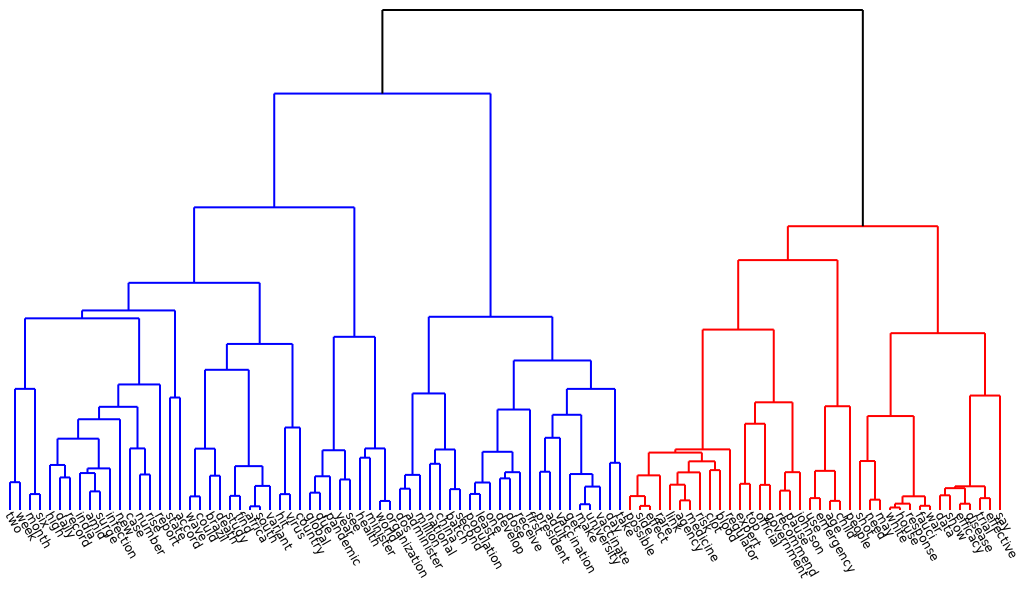

In [640]:
paris = Paris()
adjacency = nx.convert_matrix.to_numpy_array(G_reduced, nodelist = list(G_reduced.nodes))
dendrogram = paris.fit_transform(adjacency)

names = list(G_reduced.nodes)
image = svg_dendrogram(dendrogram, names, n_clusters=2, rotate=False,width=1000,height=500,filename='community_dendogram2'+period)
SVG(image)

**Metrics**

In [641]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=2, return_dendrogram=False))

community_dend = [[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.7105022831050228
Performance:  0.5690909090909091
Modularity:  0.19927116863975616


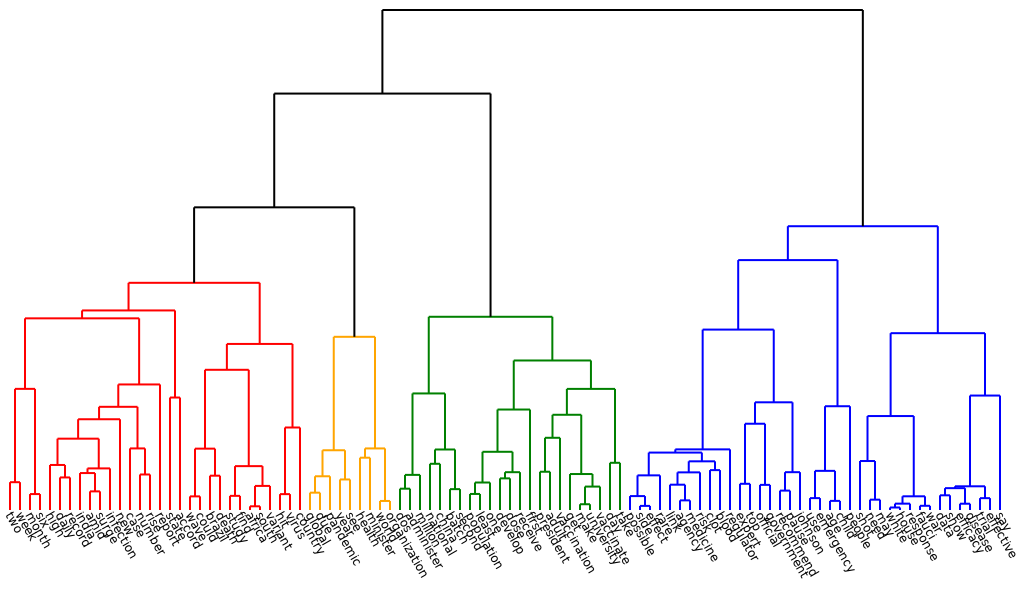

In [642]:
image = svg_dendrogram(dendrogram, names, n_clusters=4, rotate=False,width=1000,height=500,filename='community_dendogram4'+period)
SVG(image)

**Metrics**

In [643]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=4, return_dendrogram=False))

community_dend = [[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.4785388127853881
Performance:  0.7022222222222222
Modularity:  0.26175800961136225


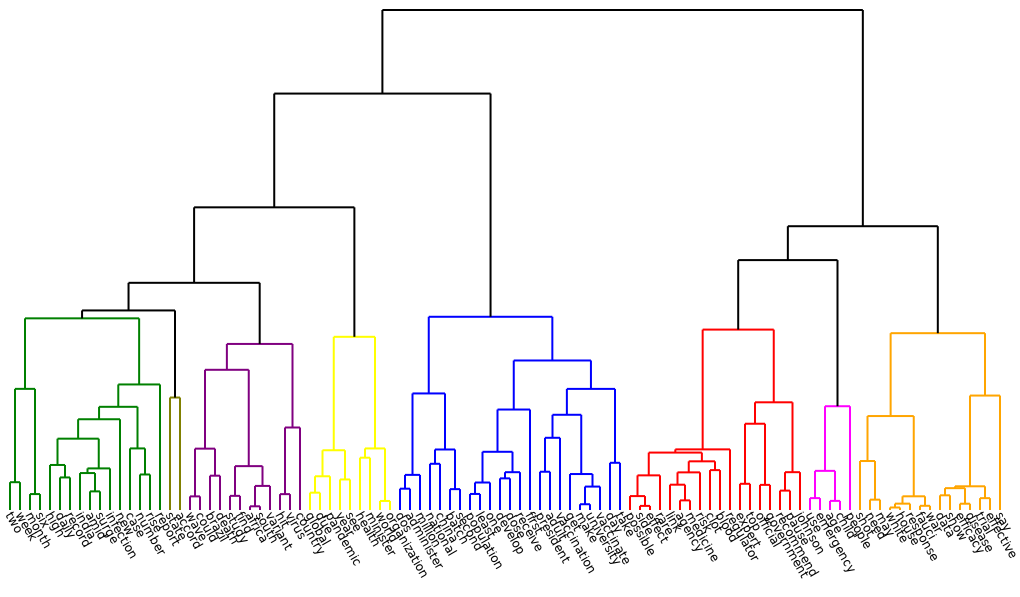

In [644]:
image = svg_dendrogram(dendrogram, names, n_clusters=8, rotate=False,width=1000,height=500,filename='community_dendogram8'+period)
SVG(image)

**Metrics**

In [645]:
nodelist = list(G_reduced.nodes)
labels = list(cut_straight(dendrogram, n_clusters=8, return_dendrogram=False))

community_dend = [[],[],[],[],[],[],[],[]]
i = 0
for node in nodelist:
  community_dend[labels[i]].append(node)
  i += 1

_ = compute_metrics(G_reduced, community_dend)

Coverage:  0.33424657534246577
Performance:  0.7763636363636364
Modularity:  0.24371611441712127


### Big clam

In [165]:
G_copy = G.copy()
G_copy = nx.convert_node_labels_to_integers(G_copy, first_label=0, ordering='sorted')

index_list = [index for index in range(G.number_of_nodes())]
node_list = sorted([node for node in G.nodes()])

clusters = big_clam(G_copy)
communities = clusters.communities

dictionary_bigClam = {}
for idx in index_list:
  dictionary_bigClam[idx] = node_list[idx]

print('Number of communities:', len(communities))

Number of communities: 4


In [166]:
bigClam_comm = [[],[],[],[]]
for c in range(len(communities)):
  for idx in range(len(communities[c])):
    bigClam_comm[c].append(dictionary_bigClam[communities[c][idx]])

print(bigClam_comm[0])
print(bigClam_comm[1])
print(bigClam_comm[2])

['across', 'add', 'administer', 'administration', 'adult', 'agency', 'air', 'allow', 'amid', 'among', 'analysis', 'animal', 'announce', 'another', 'antibody', 'approval', 'approve', 'around', 'arrive', 'ask', 'australia', 'authority', 'authorization', 'average', 'back', 'bad', 'ban', 'base', 'batch', 'become', 'begin', 'benefit', 'big', 'billion', 'black', 'block', 'boost', 'brain', 'break', 'breaking', 'bring', 'british', 'call', 'campaign', 'canada', 'care', 'cause', 'change', 'chief', 'child', 'chile', 'cite', 'city', 'close', 'come', 'committee', 'company', 'concern', 'confirm', 'consider', 'continue', 'contract', 'control', 'could', 'coverage', 'crisis', 'daily', 'data', 'deal', 'decide', 'decision', 'decline', 'deliver', 'delivery', 'detect', 'develop', 'director', 'disease', 'disorder', 'doctor', 'donate', 'double', 'drive', 'drug', 'due', 'early', 'ease', 'economy', 'effect', 'effective', 'efficacy', 'effort', 'emergency', 'end', 'even', 'event', 'ever', 'every', 'exclusive', '

In [168]:
for node in G.nodes():
  if node in bigClam_comm[0] and node in bigClam_comm[1]:
    print(node + ' is present in communities 0 and 1')
  if node in bigClam_comm[0] and node in bigClam_comm[2]:
    print(node + ' is present in communities 0 and 2')
  if node in bigClam_comm[0] and node in bigClam_comm[3]:
    print(node + ' is present in communities 1 and 2')
  if node in bigClam_comm[1] and node in bigClam_comm[2]:
    print(node + ' is present in communities 0 and 1')
  if node in bigClam_comm[1] and node in bigClam_comm[3]:
    print(node + ' is present in communities 0 and 2')
  if node in bigClam_comm[2] and node in bigClam_comm[3]:
    print(node + ' is present in communities 1 and 2')

no overlapping

In [169]:
threshold = 0.001
for i in range(len(bigClam_comm)):
  sum_China, sum_USA, sum_China_USA = community_check(bigClam_comm[i], freq_dict_China, freq_dict_USA, G_China, G_USA, threshold)
  print('Community: ', i)
  print('China: ', round(100 * sum_China / len(bigClam_comm[i])),'%')
  print('USA: ', round(100 * sum_USA / len(bigClam_comm[i])),'%')
  print('China&USA: ', round(100 * sum_China_USA / len(bigClam_comm[i])),'%')
  print()

Community:  0
China:  5 %
USA:  17 %
China&USA:  77 %

Community:  1
China:  20 %
USA:  7 %
China&USA:  73 %

Community:  2
China:  0 %
USA:  0 %
China&USA:  100 %

Community:  3
China:  50 %
USA:  0 %
China&USA:  50 %



**Metrics**

In [170]:
_ = compute_metrics(G, bigClam_comm)

Coverage:  0.39913544668587897
Performance:  0.27669835322709263
Modularity:  -0.033367932337866744


#### display

In [ ]:
colors = list(G.nodes)
i = 0
dict_nodes = {}
for node in colors:
  if node in bigClam_comm[0]:
    colors[i] = 'violet'
    dict_nodes[node] = 0
  if node in bigClam_comm[1]:
    colors[i] = 'lightcoral'
    dict_nodes[node] = 1
  if node in bigClam_comm[2]:
    colors[i] = 'lawngreen'
    dict_nodes[node] = 2
  i += 1

In [ ]:
pos = community_layout(G, dict_nodes)
fig = plt.figure(1, figsize=(200, 80), dpi=60)
nx.draw_networkx(G, pos, node_color=colors, node_size=5000, with_labels=True,
                 font_size =50,width=0.05)
plt.show()

# PageRank Networks: inside/outside separate

## **All periods**

### Download data

In [434]:
edges_China = pd.read_csv('/content/edgelist_China.csv')
edges_USA = pd.read_csv('/content/edgelist_USA.csv')

net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)

G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [435]:
print('USA is connected: ', nx.is_connected(G_USA))
print('China is connected: ', nx.is_connected(G_China))

USA is connected:  True
China is connected:  False


In [436]:
for c in nx.connected_components(G_China):
  print(c)

{'record', 'wave', 'urge', 'build', 'single', 'launch', 'express', 'start', 'step', 'country', 'phone', 'look', 'emergency', 'brazil', 'due', 'traditional', 'complete', 'leave', 'rise', 'ambassador', 'clinical', 'cause', 'surpass', 'first', 'detect', 'update', 'front', 'man', 'office', 'aid', 'effect', 'south', 'community', 'medical', 'issue', 'miss', 'sign', 'headline', 'combat', 'deal', 'trade', 'send', 'mask', 'japan', 'continue', 'symptom', 'mark', 'official', 'quarantine', 'concern', 'ensure', 'plasma', 'makeshift', 'become', 'top', 'prevention', 'tourism', 'register', 'wife', 'president', 'also', 'way', 'critical', 'link', 'taiwan', 'allow', 'coronavirus', 'die', 'check', 'director', 'release', 'dose', 'expect', 'confident', 'france', 'close', 'child', 'work', 'hubei', 'include', 'school', 'amid', 'spring', 'take', 'good', 'reporter', 'least', 'nearly', 'end', 'state', 'agency', 'safe', 'campaign', 'white', 'situation', 'join', 'nation', 'result', 'measure', 'jab', 'effort', 'sta

In [437]:
G_China.remove_node('non')
G_China.remove_node('essential')
G_China.remove_node('coronavirus')
G_China.remove_node('covid')
G_China.remove_node('vaccine')

G_USA.remove_node('coronavirus')
G_USA.remove_node('covid')
G_USA.remove_node('vaccine')

In [438]:
print('USA is connected: ', nx.is_connected(G_USA))
print('China is connected: ', nx.is_connected(G_China))

USA is connected:  True
China is connected:  False


In [439]:
for c in nx.connected_components(G_China):
  print(c)

{'record', 'wave', 'build', 'single', 'launch', 'express', 'start', 'step', 'country', 'phone', 'look', 'emergency', 'brazil', 'due', 'traditional', 'complete', 'leave', 'rise', 'ambassador', 'clinical', 'cause', 'surpass', 'first', 'detect', 'update', 'front', 'man', 'aid', 'effect', 'south', 'community', 'medical', 'issue', 'miss', 'sign', 'headline', 'combat', 'deal', 'trade', 'send', 'mask', 'japan', 'continue', 'symptom', 'official', 'quarantine', 'concern', 'ensure', 'plasma', 'makeshift', 'become', 'top', 'prevention', 'tourism', 'register', 'wife', 'president', 'also', 'way', 'critical', 'link', 'taiwan', 'die', 'check', 'director', 'release', 'dose', 'expect', 'confident', 'close', 'child', 'work', 'hubei', 'include', 'amid', 'spring', 'take', 'good', 'reporter', 'least', 'nearly', 'end', 'state', 'agency', 'safe', 'white', 'situation', 'join', 'nation', 'result', 'measure', 'jab', 'effort', 'staff', 'overseas', 'curb', 'world', 'family', 'pneumonia', 'help', 'march', 'transmi

In [440]:
disconn_keys = []
for c in nx.connected_components(G_China):
  if len(c) == 1:
    disconn_keys.append(list(c)[0])
  if len(c) == 2:
    disconn_keys.append(list(c)[0])
    disconn_keys.append(list(c)[1])

for key in disconn_keys:
  G_China.remove_node(key)

In [441]:
print('China is connected: ', nx.is_connected(G_China))

China is connected:  True


In [442]:
print('China:')
print('Nodes: ',len(G_China.nodes()))
print('Edges: ',len(G_China.edges()))
print('Is connected: ',nx.is_connected(G_China))
print()
print('USA:')
print('Nodes: ',len(G_USA.nodes()))
print('Edges: ',len(G_USA.edges()))
print('Is connected: ',nx.is_connected(G_USA))
print()

China:
Nodes:  411
Edges:  2492
Is connected:  True

USA:
Nodes:  518
Edges:  7558
Is connected:  True



In [443]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  return pd.DataFrame(l)

def threshold_reverse(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] < threshold ]

  return pd.DataFrame(l)

In [444]:
# PageRank for reducing the graph
pr_China = nx.algorithms.pagerank(G_China, alpha = 1)
pr_China = dict(sorted(pr_China.items(), key=lambda item: item[1],reverse = True))

thr_C = 0.001
print(len(threshold(pr_China,thr_C)))

pr_USA = nx.algorithms.pagerank(G_USA, alpha = 1)
pr_USA = dict(sorted(pr_USA.items(), key=lambda item: item[1],reverse = True))

thr_U = 0.00134
print(len(threshold(pr_USA,thr_U)))

150
150


In [445]:
G_reduced_China = G_China.copy()
nodes_to_delete = list(threshold_reverse(pr_China,thr_C)[0])
for n in nodes_to_delete:
    G_reduced_China.remove_node(n)

print(nx.is_connected(G_reduced_China))

G_reduced_USA = G_USA.copy()
nodes_to_delete = list(threshold_reverse(pr_USA,thr_U)[0])
for n in nodes_to_delete:
    G_reduced_USA.remove_node(n)

print(nx.is_connected(G_reduced_USA))

True
True


### Louvain Community Detection

CHINA

In [455]:
community_louv = community_louvain.best_partition(G_reduced_China,weight='weight')

In [456]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['china', 'novel', 'people', 'medium', 'make', 'take', 'medical', 'worker', 'across', 'outbreak', 'support', 'help', 'fight', 'express', 'contain', 'epidemic', 'supply', 'effort', 'send', 'amid', 'virus', 'donate', 'show', 'work', 'combat', 'measure', 'city', 'battle', 'win', 'beijing', 'pneumonia', 'spread', 'call', 'government', 'cause', 'staff']
['arrive', 'hospital', 'day', 'treatment', 'start', 'second', 'infect', 'see', 'patient', 'year', 'old', 'discharge', 'first', 'recover', 'makeshift', 'receive', 'month', 'recovery', 'time', 'build', 'construction', 'batch', 'dose', 'vaccination', 'treat', 'leishenshan']
['world', 'health', 'organization', 'international', 'expert', 'country', 'say', 'foreign', 'minister', 'use', 'authority', 'global', 'economy', 'million', 'prime', 'ministry', 'public', 'emergency', 'pandemic', 'approve', 'administer', 'dos', 'blood', 'clot']
['disease', 'live', 'state', 'prevention', 'late', 'official', 'hold', 'control', 'update', 'press', 'conference', '

In [457]:
_ = compute_metrics(G_reduced_China, community_louvain_list)

Coverage:  0.40426758938869667
Performance:  0.7809395973154363
Modularity:  0.2567156619360618


USA

In [458]:
community_louv = community_louvain.best_partition(G_reduced_USA,weight='weight')

In [459]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['south', 'confirm', 'case', 'rise', 'death', 'amid', 'report', 'total', 'number', 'infection', 'new', 'toll', 'hit', 'million', 'second', 'record', 'see', 'big', 'country', 'restriction', 'month', 'day', 'york', 'australia', 'set', 'accord', 'india', 'united', 'state', 'increase', 'high', 'daily', 'wave', 'surge', 'brazil', 'vaccination', 'dos']
['disease', 'center', 'control']
['time', 'say', 'first', 'patient', 'drug', 'three', 'home', 'test', 'positive', 'since', 'hospital', 'end', 'get', 'year', 'work', 'president', 'need', 'doctor', 'face', 'mask', 'help', 'may', 'know', 'official', 'symptom', 'week', 'plan', 'make', 'take', 'last', 'house', 'trump', 'return', 'medical', 'back', 'pandemic', 'include', 'still', 'announce', 'administration', 'top', 'lady', 'would', 'response', 'white', 'campaign', 'fauci', 'presidential', 'election', 'debate', 'joe']
['could', 'china', 'outbreak', 'late', 'world', 'people', 'infect', 'update', 'die', 'warn', 'least', 'concern', 'spread', 'follow', 

In [460]:
_ = compute_metrics(G_reduced_USA, community_louvain_list)

Coverage:  0.3556298773690078
Performance:  0.6700671140939597
Modularity:  0.20940980601052975


## **JanFeb2020**

### Download data

In [473]:
period = '_JanFeb2020'
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)

G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [474]:
print('USA is connected: ', nx.is_connected(G_USA))
print('China is connected: ', nx.is_connected(G_China))

USA is connected:  True
China is connected:  False


In [475]:
for c in nx.connected_components(G_China):
  print(c)

{'korea', 'reach', 'bed', 'economy', 'confirm', 'build', 'facility', 'say', 'contain', 'health', 'leader', 'may', 'live', 'express', 'start', 'message', 'suspected', 'step', 'team', 'novel', 'home', 'resident', 'local', 'country', 'epidemic', 'phone', 'look', 'conference', 'life', 'since', 'expert', 'positive', 'emergency', 'stay', 'old', 'read', 'due', 'impact', 'month', 'prime', 'traditional', 'complete', 'chief', 'leave', 'press', 'rise', 'cause', 'medic', 'clinical', 'test', 'jinping', 'set', 'first', 'get', 'report', 'like', 'update', 'observation', 'total', 'front', 'daily', 'public', 'ship', 'authority', 'center', 'treatment', 'special', 'research', 'travel', 'general', 'aid', 'remain', 'keep', 'severe', 'leishenshan', 'joint', 'see', 'infect', 'wish', 'province', 'another', 'south', 'community', 'outbreak', 'foreign', 'researcher', 'beijing', 'fight', 'medical', 'condition', 'miss', 'tackle', 'control', 'prevent', 'headline', 'combat', 'opinion', 'trade', 'organization', 'trans

In [476]:
G_China.remove_node('police')
G_China.remove_node('officer')
G_China.remove_node('billion')
G_China.remove_node('dollar')
G_China.remove_node('festival')
G_China.remove_node('spring')
G_China.remove_node('coronavirus')
G_China.remove_node('covid')
G_China.remove_node('vaccine')

G_USA.remove_node('coronavirus')
G_USA.remove_node('covid')
G_USA.remove_node('vaccine')

In [477]:
print('USA is connected: ', nx.is_connected(G_USA))
print('China is connected: ', nx.is_connected(G_China))

USA is connected:  False
China is connected:  True


In [478]:
for c in nx.connected_components(G_USA):
  print(c)

{'record', 'urge', 'build', 'start', 'step', 'country', 'foundation', 'emergency', 'fear', 'much', 'due', 'rise', 'leave', 'quarter', 'cause', 'stock', 'first', 'update', 'man', 'thailand', 'dock', 'singapore', 'scientist', 'investor', 'employee', 'south', 'related', 'medical', 'issue', 'mobile', 'port', 'trade', 'evacuee', 'malaysia', 'already', 'mask', 'japan', 'fall', 'continue', 'symptom', 'official', 'quarantine', 'concern', 'become', 'top', 'prevention', 'flu', 'firm', 'human', 'police', 'diamond', 'president', 'way', 'monitor', 'die', 'expect', 'france', 'close', 'price', 'work', 'include', 'hubei', 'amid', 'try', 'take', 'must', 'least', 'nearly', 'source', 'end', 'state', 'result', 'basis', 'measure', 'effort', 'curb', 'japanese', 'world', 'family', 'help', 'stop', 'facebook', 'still', 'global', 'economy', 'confirm', 'say', 'health', 'australian', 'major', 'revenue', 'resident', 'epidemic', 'liner', 'old', 'pandemic', 'cancel', 'traveler', 'chief', 'airport', 'test', 'return',

In [479]:
disconn_keys = []
for c in nx.connected_components(G_USA):
  if len(c) == 1:
    disconn_keys.append(list(c)[0])
  if len(c) == 3:
    disconn_keys.append(list(c)[0])
    disconn_keys.append(list(c)[1])
    disconn_keys.append(list(c)[2])

for key in disconn_keys:
  G_USA.remove_node(key)

In [480]:
print('USA is connected: ', nx.is_connected(G_USA))

USA is connected:  True


In [481]:
print('China:')
print('Nodes: ',len(G_China.nodes()))
print('Edges: ',len(G_China.edges()))
print('Is connected: ',nx.is_connected(G_China))
print()
print('USA:')
print('Nodes: ',len(G_USA.nodes()))
print('Edges: ',len(G_USA.edges()))
print('Is connected: ',nx.is_connected(G_USA))
print()

China:
Nodes:  293
Edges:  1300
Is connected:  True

USA:
Nodes:  316
Edges:  1305
Is connected:  True



In [482]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  return pd.DataFrame(l)

def threshold_reverse(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] < threshold ]

  return pd.DataFrame(l)

In [483]:
# PageRank for reducing the graph
pr_China = nx.algorithms.pagerank(G_China, alpha = 1)
pr_China = dict(sorted(pr_China.items(), key=lambda item: item[1],reverse = True))

thr_C = 0.000657
print(len(threshold(pr_China,thr_C)))

pr_USA = nx.algorithms.pagerank(G_USA, alpha = 1)
pr_USA = dict(sorted(pr_USA.items(), key=lambda item: item[1],reverse = True))

thr_U = 0.0007581
print(len(threshold(pr_USA,thr_U)))

150
150


In [484]:
G_reduced_China = G_China.copy()
nodes_to_delete = list(threshold_reverse(pr_China,thr_C)[0])
for n in nodes_to_delete:
    G_reduced_China.remove_node(n)

print(nx.is_connected(G_reduced_China))

G_reduced_USA = G_USA.copy()
nodes_to_delete = list(threshold_reverse(pr_USA,thr_U)[0])
for n in nodes_to_delete:
    G_reduced_USA.remove_node(n)

print(nx.is_connected(G_reduced_USA))

True
True


### Louvain Community Detection

CHINA

In [490]:
community_louv = community_louvain.best_partition(G_reduced_China,weight='weight')

In [491]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['china', 'novel', 'face', 'people', 'medium', 'world', 'make', 'disease', 'take', 'health', 'organization', 'team', 'international', 'expert', 'country', 'medical', 'worker', 'across', 'outbreak', 'support', 'help', 'fight', 'express', 'contain', 'epidemic', 'supply', 'chief', 'say', 'effort', 'send', 'amid', 'virus', 'foreign', 'minister', 'mask', 'donate', 'show', 'work', 'combat', 'around', 'development', 'die', 'measure', 'city', 'battle', 'win', 'global', 'spread', 'response', 'president', 'solidarity', 'leader', 'million', 'phone', 'call', 'together', 'doctor', 'public', 'emergency', 'cause', 'curb', 'stay', 'strong', 'time', 'director', 'confident', 'confidence', 'center', 'staff', 'xinhua', 'jinping', 'community', 'authority']
['outside', 'confirm', 'case', 'central', 'epicenter', 'hubei', 'province', 'number', 'include', 'total', 'one', 'new', 'pneumonia', 'death', 'confirmed', 'discharge', 'report', 'suspected', 'another', 'macao', 'taiwan', 'infection', 'bring', 'two', 'reg

In [492]:
_ = compute_metrics(G_reduced_China, community_louvain_list)

Coverage:  0.5935483870967742
Performance:  0.69834451901566
Modularity:  0.3052855681001033


USA

In [493]:
community_louv = community_louvain.best_partition(G_reduced_USA,weight='weight')

In [494]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['bring', 'south', 'korea', 'confirm', 'case', 'rise', 'hubei', 'province', 'death', 'first', 'report', 'three', 'total', 'number', 'infection', 'new', 'toll', 'risk', 'second', 'end', 'record', 'outside', 'lunar', 'year', 'holiday', 'country', 'authority', 'know', 'national', 'commission', 'day', 'confirmed', 'man', 'human', 'accord', 'include', 'across', 'increase', 'high', 'top']
['evacuate', 'two', 'diamond', 'princess', 'cruise', 'ship', 'test', 'positive', 'quarantine', 'government', 'japan', 'hong', 'become', 'week', 'passenger', 'dock', 'board']
['could', 'world', 'say', 'patient', 'drug', 'concern', 'hospital', 'health', 'global', 'early', 'doctor', 'public', 'declare', 'emergency', 'official', 'organization', 'take', 'medical', 'international', 'treatment']
['china', 'outbreak', 'late', 'epidemic', 'update', 'warn', 'amid', 'business', 'hit', 'follow', 'economy', 'citizen', 'fear', 'million', 'level', 'due', 'city', 'contain', 'president', 'deadly', 'face', 'mask', 'help', 'b

In [495]:
_ = compute_metrics(G_reduced_USA, community_louvain_list)

Coverage:  0.45489443378119004
Performance:  0.7671588366890381
Modularity:  0.26990218047270764


## **SeptOct2020**

### Download data

In [496]:
period = '_SeptOct2020'
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)

G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [497]:
print('USA is connected: ', nx.is_connected(G_USA))
print('China is connected: ', nx.is_connected(G_China))

USA is connected:  True
China is connected:  False


In [498]:
for c in nx.connected_components(G_China):
  print(c)

{'global', 'reach', 'record', 'past', 'wave', 'economy', 'confirm', 'say', 'health', 'may', 'live', 'trial', 'surge', 'post', 'secretary', 'locally', 'local', 'economic', 'country', 'epidemic', 'since', 'expert', 'positive', 'brazil', 'pandemic', 'due', 'prime', 'house', 'rise', 'surpass', 'reopen', 'cause', 'leave', 'twitter', 'clinical', 'test', 'jinping', 'first', 'report', 'get', 'total', 'watch', 'develop', 'daily', 'authority', 'center', 'general', 'diagnosis', 'remain', 'russia', 'qingdao', 'see', 'sar', 'dos', 'wish', 'outbreak', 'reed', 'york', 'sept', 'fight', 'import', 'medical', 'statement', 'india', 'control', 'boost', 'increase', 'study', 'organization', 'accord', 'trump', 'send', 'across', 'support', 'continue', 'recovery', 'disease', 'case', 'governor', 'official', 'quarantine', 'two', 'set', 'minister', 'toll', 'top', 'prevention', 'city', 'late', 'tourism', 'walter', 'international', 'protection', 'joe', 'show', 'virus', 'register', 'wife', 'commission', 'bring', 'pre

In [499]:
G_China.remove_node('billion')
G_China.remove_node('dollar')
G_China.remove_node('coronavirus')
G_China.remove_node('covid')
G_China.remove_node('vaccine')

G_USA.remove_node('coronavirus')
G_USA.remove_node('covid')
G_USA.remove_node('vaccine')

In [500]:
print('USA is connected: ', nx.is_connected(G_USA))
print('China is connected: ', nx.is_connected(G_China))

USA is connected:  False
China is connected:  False


In [501]:
for c in nx.connected_components(G_USA):
  print(c)

{'jersey', 'record', 'ask', 'wave', 'urge', 'single', 'happen', 'start', 'message', 'country', 'look', 'expose', 'young', 'rally', 'emergency', 'much', 'fear', 'brazil', 'due', 'rise', 'surpass', 'leave', 'cause', 'clinical', 'stock', 'authorization', 'serious', 'first', 'update', 'even', 'relief', 'office', 'aid', 'turn', 'effect', 'maker', 'scientist', 'investor', 'job', 'employee', 'south', 'seek', 'medical', 'issue', 'sign', 'deal', 'already', 'ten', 'send', 'mask', 'fauci', 'fall', 'right', 'candidate', 'continue', 'symptom', 'mark', 'court', 'winter', 'official', 'quarantine', 'review', 'supporter', 'cut', 'concern', 'previous', 'become', 'top', 'flu', 'firm', 'joe', 'race', 'package', 'wife', 'president', 'way', 'also', 'half', 'clear', 'allow', 'die', 'struggle', 'director', 'release', 'dose', 'food', 'stage', 'expect', 'france', 'close', 'child', 'work', 'include', 'school', 'amid', 'believe', 'try', 'take', 'good', 'speaker', 'nancy', 'least', 'nearly', 'democrat', 'immune', 

In [502]:
disconn_keys = []
for c in nx.connected_components(G_USA):
  if len(c) == 1:
    disconn_keys.append(list(c)[0])

for key in disconn_keys:
  G_USA.remove_node(key)

In [503]:
print('USA is connected: ', nx.is_connected(G_USA))

USA is connected:  True


In [504]:
for c in nx.connected_components(G_China):
  print(c)

{'global', 'past', 'record', 'reach', 'economy', 'confirm', 'say', 'health', 'may', 'surge', 'locally', 'local', 'economic', 'country', 'epidemic', 'since', 'expert', 'positive', 'brazil', 'pandemic', 'due', 'prime', 'house', 'rise', 'surpass', 'leave', 'twitter', 'test', 'jinping', 'first', 'report', 'total', 'daily', 'authority', 'center', 'diagnosis', 'remain', 'russia', 'qingdao', 'see', 'sar', 'wish', 'reed', 'york', 'fight', 'import', 'medical', 'statement', 'india', 'control', 'boost', 'increase', 'organization', 'accord', 'trump', 'send', 'support', 'recovery', 'disease', 'case', 'governor', 'official', 'quarantine', 'two', 'set', 'minister', 'toll', 'prevention', 'city', 'tourism', 'walter', 'protection', 'show', 'joe', 'register', 'wife', 'commission', 'bring', 'president', 'italy', 'china', 'golden', 'doctor', 'lady', 'day', 'far', 'tally', 'million', 'time', 'africa', 'cite', 'united', 'expect', 'vice', 'include', 'amid', 'infection', 'medium', 'take', 'six', 'hard', 'hospi

In [505]:
disconn_keys = []
for c in nx.connected_components(G_China):
  if len(c) == 1:
    disconn_keys.append(list(c)[0])
  if len(c) == 2:
    disconn_keys.append(list(c)[0])
    disconn_keys.append(list(c)[1])
  if len(c) == 3:
    disconn_keys.append(list(c)[0])
    disconn_keys.append(list(c)[1])
    disconn_keys.append(list(c)[2])

for key in disconn_keys:
  G_China.remove_node(key)

In [506]:
print('China is connected: ', nx.is_connected(G_China))

China is connected:  True


In [507]:
print('China:')
print('Nodes: ',len(G_China.nodes()))
print('Edges: ',len(G_China.edges()))
print('Is connected: ',nx.is_connected(G_China))
print()
print('USA:')
print('Nodes: ',len(G_USA.nodes()))
print('Edges: ',len(G_USA.edges()))
print('Is connected: ',nx.is_connected(G_USA))
print()

China:
Nodes:  132
Edges:  389
Is connected:  True

USA:
Nodes:  493
Edges:  3842
Is connected:  True



In [508]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  return pd.DataFrame(l)

def threshold_reverse(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] < threshold ]

  return pd.DataFrame(l)

In [509]:
# PageRank for reducing the graph
pr_China = nx.algorithms.pagerank(G_China, alpha = 1)
pr_China = dict(sorted(pr_China.items(), key=lambda item: item[1],reverse = True))

thr_C = 0
print(len(threshold(pr_China,thr_C)))

pr_USA = nx.algorithms.pagerank(G_USA, alpha = 1)
pr_USA = dict(sorted(pr_USA.items(), key=lambda item: item[1],reverse = True))

thr_U = 0.00149
print(len(threshold(pr_USA,thr_U)))

132
131


In [510]:
G_reduced_China = G_China.copy()

print(nx.is_connected(G_reduced_China))

G_reduced_USA = G_USA.copy()
nodes_to_delete = list(threshold_reverse(pr_USA,thr_U)[0])
for n in nodes_to_delete:
    G_reduced_USA.remove_node(n)

print(nx.is_connected(G_reduced_USA))

True
True


### Louvain Community Detection

CHINA

In [512]:
community_louv = community_louvain.best_partition(G_reduced_China,weight='weight')

In [513]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['state', 'united', 'nation']
['daily', 'case', 'infection', 'high', 'number', 'new', 'record', 'report', 'since', 'see', 'take', 'confirm', 'one', 'health', 'accord', 'ministry', 'register', 'overseas', 'national', 'commission', 'announce', 'university', 'local', 'increase', 'surge', 'official', 'bring', 'total', 'confirmed', 'tally', 'rise', 'death', 'protection', 'past', 'hour', 'city', 'far', 'include', 'russia', 'qingdao', 'two', 'authority', 'six', 'locally', 'transmit', 'region', 'sar', 'import', 'toll', 'york', 'may', 'set', 'italy', 'governor', 'cite']
['surpass', 'million', 'pandemic', 'country', 'global', 'world', 'amid', 'due', 'development', 'india', 'brazil', 'organization']
['week', 'china', 'day', 'year', 'economy', 'recovery', 'epidemic', 'holiday', 'find', 'economic', 'fight', 'medium', 'support', 'show', 'tourism', 'hard', 'golden', 'boost', 'end', 'expect']
['africa', 'center', 'reach', 'control', 'disease', 'prevention']
['first', 'people', 'positive', 'say', 'test

In [514]:
_ = compute_metrics(G_reduced_China, community_louvain_list)

Coverage:  0.7069408740359897
Performance:  0.7423085820032385
Modularity:  0.37270457166435067


USA

In [515]:
community_louv = community_louvain.best_partition(G_reduced_USA,weight='weight')

In [516]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['global', 'could', 'world', 'one', 'health', 'pandemic', 'people', 'use', 'may', 'accord', 'face', 'mask', 'work', 'time', 'disease', 'die', 'help', 'emergency', 'year', 'public', 'expert', 'home']
['case', 'million', 'death', 'china', 'record', 'day', 'new', 'rise', 'since', 'spread', 'india', 'see', 'month', 'week', 'report', 'second', 'country', 'high', 'daily', 'number', 'infection', 'increase', 'australia', 'outbreak', 'last', 'wave', 'state', 'surge', 'hit', 'city', 'restriction', 'two', 'york']
['say', 'test', 'plan', 'doctor', 'trump', 'negative', 'president', 'diagnosis', 'experimental', 'drug', 'hospital', 'white', 'house', 'treatment', 'military', 'positive', 'staff', 'official', 'patient', 'virus', 'symptom', 'three', 'risk', 'top', 'take', 'still', 'chief', 'announce', 'presidential', 'nominee', 'joe', 'late', 'election', 'close', 'administration', 'campaign', 'first', 'antibody', 'back', 'return', 'debate', 'democratic', 'relief', 'aid', 'vice', 'mike', 'penny', 'medical

In [517]:
_ = compute_metrics(G_reduced_USA, community_louvain_list)

Coverage:  0.4859349145063431
Performance:  0.6973576042278332
Modularity:  0.2649461030088732


## **MarchApril2021**

### Download data

In [518]:
period = '_MarchApril2021'
edges_China = pd.read_csv('/content/edgelist_China'+period+'.csv')
edges_USA = pd.read_csv('/content/edgelist_USA'+period+'.csv')

net_China, _ = network_from_edges(edges_China)
net_USA, _ = network_from_edges(edges_USA)

G_China = get_graph(net_China)
G_USA = get_graph(net_USA)

In [519]:
print('USA is connected: ', nx.is_connected(G_USA))
print('China is connected: ', nx.is_connected(G_China))

USA is connected:  True
China is connected:  True


In [520]:
G_China.remove_node('coronavirus')
G_China.remove_node('covid')
G_China.remove_node('vaccine')

G_USA.remove_node('coronavirus')
G_USA.remove_node('covid')
G_USA.remove_node('vaccine')

In [521]:
print('USA is connected: ', nx.is_connected(G_USA))
print('China is connected: ', nx.is_connected(G_China))

USA is connected:  False
China is connected:  False


In [522]:
for c in nx.connected_components(G_USA):
  print(c)

{'record', 'ask', 'wave', 'urge', 'single', 'fourth', 'start', 'country', 'look', 'young', 'emergency', 'much', 'brazil', 'due', 'rise', 'surpass', 'cause', 'clinical', 'authorization', 'first', 'update', 'even', 'office', 'thailand', 'effect', 'maker', 'scientist', 'south', 'speak', 'seek', 'medical', 'issue', 'union', 'send', 'intensive', 'mask', 'fauci', 'fall', 'right', 'continue', 'official', 'review', 'committee', 'concern', 'reason', 'block', 'become', 'top', 'outweigh', 'joe', 'president', 'way', 'evidence', 'suffer', 'half', 'link', 'allow', 'director', 'survivor', 'forward', 'dose', 'expect', 'program', 'france', 'close', 'child', 'work', 'include', 'school', 'amid', 'take', 'must', 'least', 'nearly', 'source', 'end', 'state', 'agency', 'safe', 'campaign', 'white', 'join', 'nation', 'result', 'forecast', 'adult', 'effort', 'efficacy', 'world', 'potential', 'help', 'possible', 'stop', 'facebook', 'still', 'global', 'exclusive', 'delivery', 'say', 'eligible', 'health', 'major',

In [523]:
disconn_keys = []
for c in nx.connected_components(G_USA):
  if len(c) == 1:
    disconn_keys.append(list(c)[0])
  if len(c) == 3:
    disconn_keys.append(list(c)[0])
    disconn_keys.append(list(c)[1])
    disconn_keys.append(list(c)[2])

for key in disconn_keys:
  G_USA.remove_node(key)

In [524]:
print('USA is connected: ', nx.is_connected(G_USA))

USA is connected:  True


In [525]:
for c in nx.connected_components(G_China):
  print(c)

{'record', 'confirm', 'say', 'health', 'surge', 'locally', 'vaccination', 'start', 'local', 'country', 'since', 'expert', 'emergency', 'brazil', 'pandemic', 'side', 'prime', 'plant', 'first', 'administer', 'report', 'get', 'total', 'develop', 'daily', 'authority', 'center', 'rare', 'effect', 'dos', 'province', 'south', 'foreign', 'york', 'variant', 'shipment', 'control', 'age', 'organization', 'accord', 'medicine', 'across', 'disease', 'case', 'company', 'official', 'minister', 'toll', 'produce', 'receive', 'prevention', 'yunnan', 'city', 'late', 'show', 'use', 'virus', 'register', 'animal', 'news', 'commission', 'president', 'hand', 'china', 'last', 'purchase', 'link', 'blood', 'data', 'day', 'million', 'dose', 'africa', 'united', 'include', 'donate', 'infection', 'batch', 'least', 'nearly', 'make', 'new', 'risk', 'goal', 'death', 'ministry', 'state', 'agency', 'national', 'origin', 'approve', 'year', 'clot', 'people', 'jab', 'arrive', 'michigan', 'shot', 'donation', 'high', 'overseas

In [526]:
disconn_keys = []
for c in nx.connected_components(G_China):
  if len(c) == 1:
    disconn_keys.append(list(c)[0])
  if len(c) == 2:
    disconn_keys.append(list(c)[0])
    disconn_keys.append(list(c)[1])
  if len(c) == 3:
    disconn_keys.append(list(c)[0])
    disconn_keys.append(list(c)[1])
    disconn_keys.append(list(c)[2])

for key in disconn_keys:
  G_China.remove_node(key)

In [527]:
print('China is connected: ', nx.is_connected(G_China))

China is connected:  True


In [528]:
print('China:')
print('Nodes: ',len(G_China.nodes()))
print('Edges: ',len(G_China.edges()))
print('Is connected: ',nx.is_connected(G_China))
print()
print('USA:')
print('Nodes: ',len(G_USA.nodes()))
print('Edges: ',len(G_USA.edges()))
print('Is connected: ',nx.is_connected(G_USA))
print()

China:
Nodes:  113
Edges:  361
Is connected:  True

USA:
Nodes:  341
Edges:  1390
Is connected:  True



In [529]:
def threshold(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] >= threshold ]

  return pd.DataFrame(l)

def threshold_reverse(vector,threshold):

  l = [(el,vector[el]) for el in vector if vector[el] < threshold ]

  return pd.DataFrame(l)

In [530]:
# PageRank for reducing the graph
pr_China = nx.algorithms.pagerank(G_China, alpha = 1)
pr_China = dict(sorted(pr_China.items(), key=lambda item: item[1],reverse = True))

thr_C = 0
print(len(threshold(pr_China,thr_C)))

pr_USA = nx.algorithms.pagerank(G_USA, alpha = 1)
pr_USA = dict(sorted(pr_USA.items(), key=lambda item: item[1],reverse = True))

thr_U = 0.0018
print(len(threshold(pr_USA,thr_U)))

113
114


In [531]:
print(nx.is_connected(G_reduced_China))

G_reduced_USA = G_USA.copy()
nodes_to_delete = list(threshold_reverse(pr_USA,thr_U)[0])
for n in nodes_to_delete:
    G_reduced_USA.remove_node(n)

print(nx.is_connected(G_reduced_USA))

True
True


### Louvain Community Detection

CHINA

In [536]:
community_louv = community_louvain.best_partition(G_reduced_China,weight='weight')

In [537]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['daily', 'case', 'infection', 'high', 'number', 'new', 'record', 'report', 'since', 'surpass', 'million', 'take', 'confirm', 'one', 'health', 'country', 'accord', 'ministry', 'register', 'overseas', 'national', 'commission', 'university', 'local', 'increase', 'surge', 'official', 'bring', 'total', 'confirmed', 'tally', 'rise', 'death', 'protection', 'past', 'hour', 'far', 'include', 'russia', 'two', 'authority', 'six', 'locally', 'transmit', 'region', 'sar', 'import', 'toll', 'york', 'may', 'set', 'italy', 'governor', 'india', 'brazil', 'cite']
['see', 'week', 'pandemic', 'city', 'china', 'day', 'qingdao', 'year', 'economy', 'amid', 'recovery', 'due', 'epidemic', 'holiday', 'find', 'economic', 'fight', 'medium', 'support', 'show', 'tourism', 'hard', 'golden', 'boost', 'end', 'expect']
['global', 'world', 'development', 'organization']
['first', 'announce', 'people', 'positive', 'africa', 'center', 'say', 'state', 'test', 'minister', 'spread', 'president', 'trump', 'white', 'house', 't

In [538]:
_ = compute_metrics(G_reduced_China, community_louvain_list)

Coverage:  0.7506426735218509
Performance:  0.6864445986583391
Modularity:  0.3629753184077904


USA

In [539]:
community_louv = community_louvain.best_partition(G_reduced_USA,weight='weight')

In [540]:
max = np.max(list(community_louv.values()))
community_louvain_list = []
for i in range(max+1):
  community_louvain_list.append([])
for key in list(community_louv.keys()):
  community_louvain_list[community_louv[key]].append(key)
for i in range(max+1):
  print(community_louvain_list[i])

['state', 'month', 'india', 'new', 'daily', 'infection', 'high', 'report', 'case', 'study', 'brazil', 'variant', 'record', 'rise', 'accord', 'death', 'virus', 'wave', 'day', 'third', 'china', 'hit', 'surge', 'amid', 'number']
['say', 'trial', 'supply', 'disease', 'could', 'expert', 'south', 'effective', 'prevent', 'child', 'due', 'show', 'top', 'president', 'week', 'may', 'need', 'data', 'analysis', 'safe', 'symptomatic', 'efficacy', 'infectious']
['year', 'receive', 'people', 'two', 'least', 'million', 'first', 'way', 'make', 'dos', 'much', 'one', 'vaccinate', 'vaccination', 'adult', 'get', 'population', 'second', 'university', 'australia', 'take', 'administer', 'dose', 'plan']
['pandemic', 'patient', 'leader', 'speak', 'air', 'team', 'doctor', 'response', 'war', 'white', 'house', 'fauci', 'special']
['six', 'emergency', 'risk', 'blood', 'clot', 'use', 'johnson', 'shot', 'find', 'medicine', 'regulator', 'possible', 'link', 'effect', 'concern', 'side', 'agency', 'rare', 'recommend', 'p

In [541]:
_ = compute_metrics(G_reduced_USA, community_louvain_list)

Coverage:  0.47919010123734535
Performance:  0.8118304611085235
Modularity:  0.3316358062871719
